# 0.0 IMPORTS

In [1]:
import dataframe_image as dfi
import inflection
import json
import math
import numpy as np
import pandas as pd
import pickle
import random
import requests
import seaborn as sns
import xgboost as xgb
import warnings
warnings.filterwarnings('ignore')

from boruta                import BorutaPy
from flask                 import Flask, request, Response
from IPython.core.display  import HTML
from IPython.display       import Image
from scipy                 import stats as ss
from sklearn.ensemble      import RandomForestRegressor
from sklearn.linear_model  import LinearRegression, Lasso
from sklearn.metrics       import mean_absolute_error, mean_squared_error
from sklearn.preprocessing import RobustScaler, MinMaxScaler, LabelEncoder
from tabulate              import tabulate

## 0.1 Helper Functions

In [2]:
def jupyter_settings():
    %matplotlib inline
    %pylab inline
    
    plt.style.use( 'bmh' )
    plt.rcParams['figure.figsize'] = [25, 12]
    plt.rcParams['font.size'] = 24
    
    display( HTML( '<style>.container { width:100% !important; }</style>') )
    pd.options.display.max_columns = None
    pd.options.display.max_rows = None
    pd.set_option( 'display.expand_frame_repr', False )
    
    sns.set()
    
jupyter_settings()
    
def cramer_v(x, y):
    # contingency table from all all categorical variables
    cm = pd.crosstab(x, y).to_numpy()
    # sum contingency table values
    n = cm.sum()
    # rows and cols
    r, k = cm.shape
    # chi2
    chi2 = ss.chi2_contingency(cm)[0]
    # chi2 correction
    chi2corr = max(0 , chi2 - (k - 1) * (r - 1) / (n - 1))
    # k correction
    kcorr = k - (k-1)**2 / (n - 1)
    # r correction
    rcorr = r - (r-1)**2 / (n - 1) 
    # v_cramer
    return np.sqrt( (chi2corr / n) / (min(kcorr - 1, rcorr - 1)))

def mean_absolute_percentage_error(y, yhat):
    #MAPE function
    return np.mean(np.abs((y - yhat) / y))

def mean_percentage_error(y, yhat):
    #MPE function
    return np.mean((y - yhat) / y)

def ml_error(model_name, y, yhat):
    mae = mean_absolute_error(y, yhat)
    mape = mean_absolute_percentage_error(y, yhat)
    rmse = np.sqrt(mean_squared_error(y, yhat))
    
    return pd.DataFrame({'MAE': mae,
                         'MAPE': mape,
                         'RMSE': rmse}, index = [model_name])

def cross_validation(model_name, model, x_training, kfold, verbose = False):

    mae_list = []
    mape_list = []
    rmse_list = []
    
    for k in reversed(range(1, kfold + 1)):
        
        if verbose:
            print(f'\nKFold Number: {k}')
        # start and end date for validation
        
        validation_start_date = x_training['date'].max() - datetime.timedelta(days = k * 7 * 6)
        validation_end_date = x_training['date'].max() - datetime.timedelta(days = (k - 1) * 6 * 7)
        
        # filtering dataset
        
        training = x_training[x_training['date'] < validation_start_date]
        validation = x_training[(x_training['date'] >= validation_start_date) & (x_training['date'] <= validation_end_date)]
        
        # training and validation dataset
        
        # training
        xtraining = training.drop(['date', 'sales'], axis = 1)
        ytraining = training['sales']
        
        # validation
        xvalidation = validation.drop(['date', 'sales'], axis = 1)
        yvalidation = validation['sales']
        
        # model
        m = model.fit(xtraining, ytraining)
        # prediction
        yhat = m.predict(xvalidation)
        # performance
        m_result = ml_error(model_name, np.expm1(yvalidation), np.expm1(yhat))
        
        # store iteration's performance
        mae_list.append(m_result['MAE'])
        mape_list.append(m_result['MAPE'])
        rmse_list.append(m_result['RMSE'])
        
    return pd.DataFrame({'MAE CV' : np.round(np.mean(mae_list), 2).astype(str) + ' +/- ' + np.round(np.std(mae_list), 2).astype(str),
                         'MAPE CV' : np.round(np.mean(mape_list), 2).astype(str) + ' +/- ' + np.round(np.std(mape_list), 2).astype(str),
                         'RMSE CV' : np.round(np.mean(rmse_list), 2).astype(str) + ' +/- ' + np.round(np.std(rmse_list), 2).astype(str),
                        }, index = [model_name])

Populating the interactive namespace from numpy and matplotlib


## 0.2 Loading Data

In [3]:
# loading datasets

df_sales_raw = pd.read_csv('data/train.csv', low_memory = False)
df_store_raw = pd.read_csv('data/store.csv', low_memory = False)

# merging datasets

df_raw = pd.merge(df_sales_raw, df_store_raw, how = 'left', on = 'Store')

# 1.0 DATA DESCRIPTION

In [4]:
df1 = df_raw.copy()

## 1.1 Rename Columns

In [5]:
# original name of the columns

cols_old = ['Store', 'DayOfWeek', 'Date', 'Sales', 'Customers', 'Open', 'Promo',
            'StateHoliday', 'SchoolHoliday', 'StoreType', 'Assortment',
            'CompetitionDistance', 'CompetitionOpenSinceMonth',
            'CompetitionOpenSinceYear', 'Promo2', 'Promo2SinceWeek',
            'Promo2SinceYear', 'PromoInterval']

# using inflection to create the new cols

snake_case = lambda x: inflection.underscore(x)

cols_new = list(map(snake_case, cols_old))

# renaming the cols

df1.columns = cols_new

## 1.2 - Data Dimension

In [6]:
# dataset's size

print(f'Number of rows:\t\t {df1.shape[0]}')
print(f'Number of columns:\t {df1.shape[1]}')

Number of rows:		 1017209
Number of columns:	 18


## 1.3 - Data Types

In [7]:
# transforming date to datetime

df1['date'] = pd.to_datetime(df1['date'])
df1.dtypes

store                                    int64
day_of_week                              int64
date                            datetime64[ns]
sales                                    int64
customers                                int64
open                                     int64
promo                                    int64
state_holiday                           object
school_holiday                           int64
store_type                              object
assortment                              object
competition_distance                   float64
competition_open_since_month           float64
competition_open_since_year            float64
promo2                                   int64
promo2_since_week                      float64
promo2_since_year                      float64
promo_interval                          object
dtype: object

## 1.4 - Check NAs

In [8]:
df1.isna().sum().sort_values()

store                                0
promo2                               0
assortment                           0
store_type                           0
state_holiday                        0
promo                                0
school_holiday                       0
customers                            0
sales                                0
date                                 0
day_of_week                          0
open                                 0
competition_distance              2642
competition_open_since_month    323348
competition_open_since_year     323348
promo2_since_year               508031
promo2_since_week               508031
promo_interval                  508031
dtype: int64

## 1.5 Fill Out NAs

In [9]:
# competition_distance

max_value = df1['competition_distance'].max()

df1['competition_distance'] = df1['competition_distance'].apply(lambda x: max_value * 2 if math.isnan(x) else x)

# competition_open_since_month

df1['competition_open_since_month'] = df1.apply(lambda x: x['date'].month if math.isnan(x['competition_open_since_month']) else x['competition_open_since_month'], axis = 1)

# competition_open_since_year 

df1['competition_open_since_year'] = df1.apply(lambda x: x['date'].year if math.isnan(x['competition_open_since_year']) else x['competition_open_since_year'], axis = 1)

# promo2_since_week  

df1['promo2_since_week'] = df1.apply(lambda x: x['date'].week if math.isnan(x['promo2_since_week']) else x['promo2_since_week'], axis = 1)

# promo2_since_year

df1['promo2_since_year'] = df1.apply(lambda x: x['date'].year if math.isnan(x['promo2_since_year']) else x['promo2_since_year'], axis = 1)

# promo_interval           

month_map = {1:'Jan',
             2:'Feb',
             3:'Mar',
             4:'Apr',
             5:'Mai',
             6:'Jun',
             7:'Jul',
             8:'Aug',
             9:'Sep',
             10:'Oct',
             11:'Nov',
             12:'Dec'}

df1['promo_interval'].fillna(0, inplace = True)

df1['month_map'] = df1['date'].dt.month.map(month_map)

df1['is_promo'] = df1[['promo_interval', 'month_map']].apply(lambda x: 0 if x['promo_interval'] == 0 else 1 if x['month_map'] in x['promo_interval'].split(',') else 0, axis = 1)

In [10]:
df1.isna().sum()

store                           0
day_of_week                     0
date                            0
sales                           0
customers                       0
open                            0
promo                           0
state_holiday                   0
school_holiday                  0
store_type                      0
assortment                      0
competition_distance            0
competition_open_since_month    0
competition_open_since_year     0
promo2                          0
promo2_since_week               0
promo2_since_year               0
promo_interval                  0
month_map                       0
is_promo                        0
dtype: int64

## 1.6 Change Types

In [11]:
# changing the variable type from float to int

df1['competition_open_since_month'] = df1['competition_open_since_month'].astype(int)

df1['competition_open_since_year'] = df1['competition_open_since_year'].astype(int)

df1['promo2_since_week'] = df1['promo2_since_week'].astype(int)

df1['promo2_since_year'] = df1['promo2_since_year'].astype(int)

## 1.7 Descriptive Statistics

In [12]:
num_att = df1.select_dtypes(include = ['int32', 'int64', 'float64'])

cat_att = df1.select_dtypes(exclude = ['int32', 'int64', 'float64', 'datetime64[ns]'])

### 1.7.1 - Nummerical Attributes

In [13]:
# central tendency - mean, median

ct1 = pd.DataFrame(num_att.apply(np.mean)).T

ct2 = pd.DataFrame(num_att.apply(np.median)).T

# dispersion - standard deviation, min, max, range, skew, kurtosis

d1 = pd.DataFrame(num_att.apply(np.std)).T

d2 = pd.DataFrame(num_att.apply(min)).T

d3 = pd.DataFrame(num_att.apply(max)).T

d4 = pd.DataFrame(num_att.apply(lambda x: x.max() - x.min())).T

d5 = pd.DataFrame(num_att.apply(lambda x: x.skew())).T

d6 = pd.DataFrame(num_att.apply(lambda x: x.kurtosis())).T

# concatenate

m = pd.concat((d2, d3, d4, ct1, ct2, d1, d5, d6)).T.reset_index()

m.columns = ['attributes', 'min', 'max', 'range', 'mean', 'median', 'std', 'skew', 'kurtosis']

m

,attributes,min,max,range,mean,median,std,skew,kurtosis
0,store,1.0,1115.0,1114.0,558.429727,558.0,321.908493,-0.000955,-1.200524
1,day_of_week,1.0,7.0,6.0,3.998341,4.0,1.997390,0.001593,-1.246873
2,sales,0.0,41551.0,41551.0,5773.818972,5744.0,3849.924283,0.641460,1.778375
3,customers,0.0,7388.0,7388.0,633.145946,609.0,464.411506,1.598650,7.091773
4,open,0.0,1.0,1.0,0.830107,1.0,0.375539,-1.758045,1.090723
5,promo,0.0,1.0,1.0,0.381515,0.0,0.485758,0.487838,-1.762018
6,school_holiday,0.0,1.0,1.0,0.178647,0.0,0.383056,1.677842,0.815154
7,competition_distance,20.0,151720.0,151700.0,5810.044888,2330.0,10715.007635,7.593832,90.447876
8,competition_open_since_month,1.0,12.0,11.0,6.786849,7.0,3.311085,-0.042076,-1.232607
9,competition_open_since_year,1900.0,2015.0,115.0,2010.324840,2012.0,5.515591,-7.235657,124.071304


### 1.7.2 - Categorical Attributes

In [14]:
cat_att.apply(lambda x: x.unique().shape[0])

state_holiday      4
store_type         4
assortment         3
promo_interval     4
month_map         12
dtype: int64

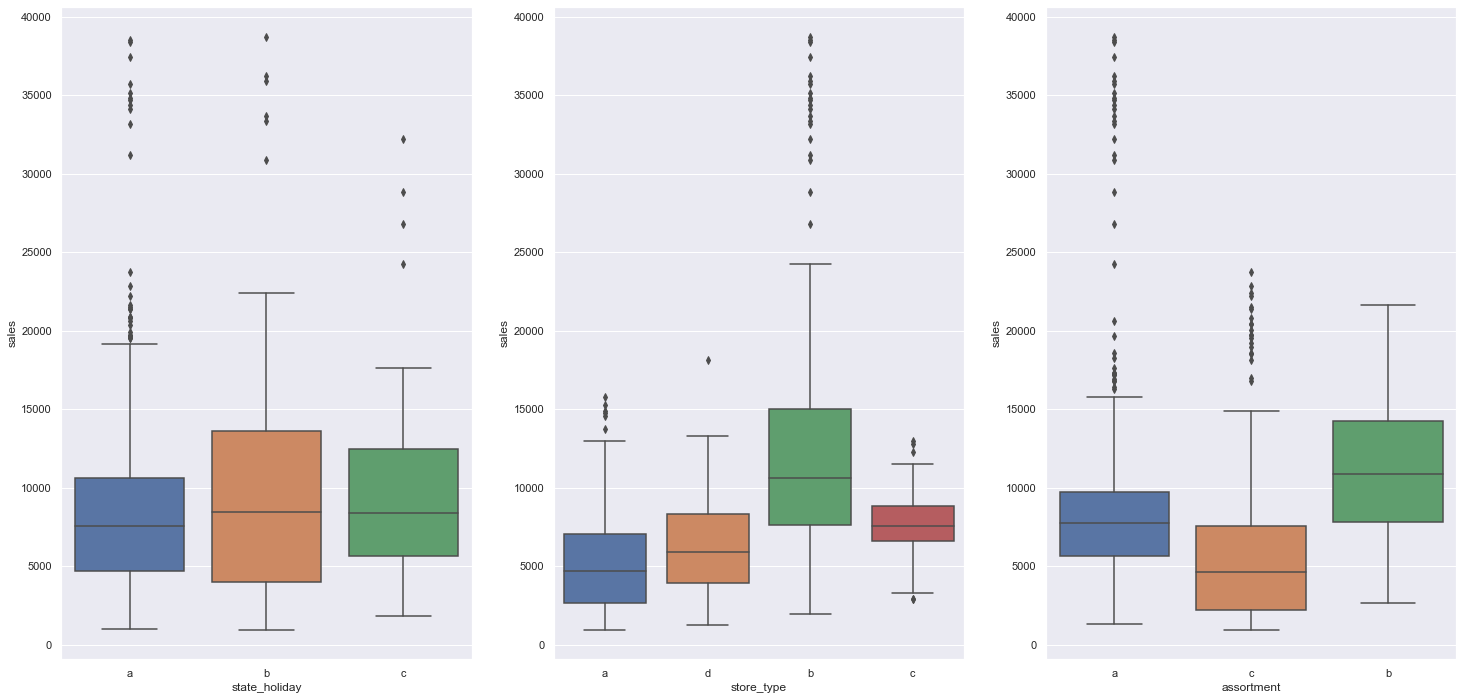

In [15]:
aux1 = df1[(df1['state_holiday'] != '0') & (df1['sales'] > 0)]
plt.subplot(1, 3, 1)
sns.boxplot(x = 'state_holiday', y = 'sales', data = aux1)
plt.subplot(1, 3, 2)
sns.boxplot(x = 'store_type', y = 'sales', data = aux1)
plt.subplot(1, 3, 3)
sns.boxplot(x = 'assortment', y = 'sales', data = aux1);

# 2.0 FEATURE ENGINEERING

In [16]:
df2 = df1.copy()

## 2.1 Mindmap Hyphotesis

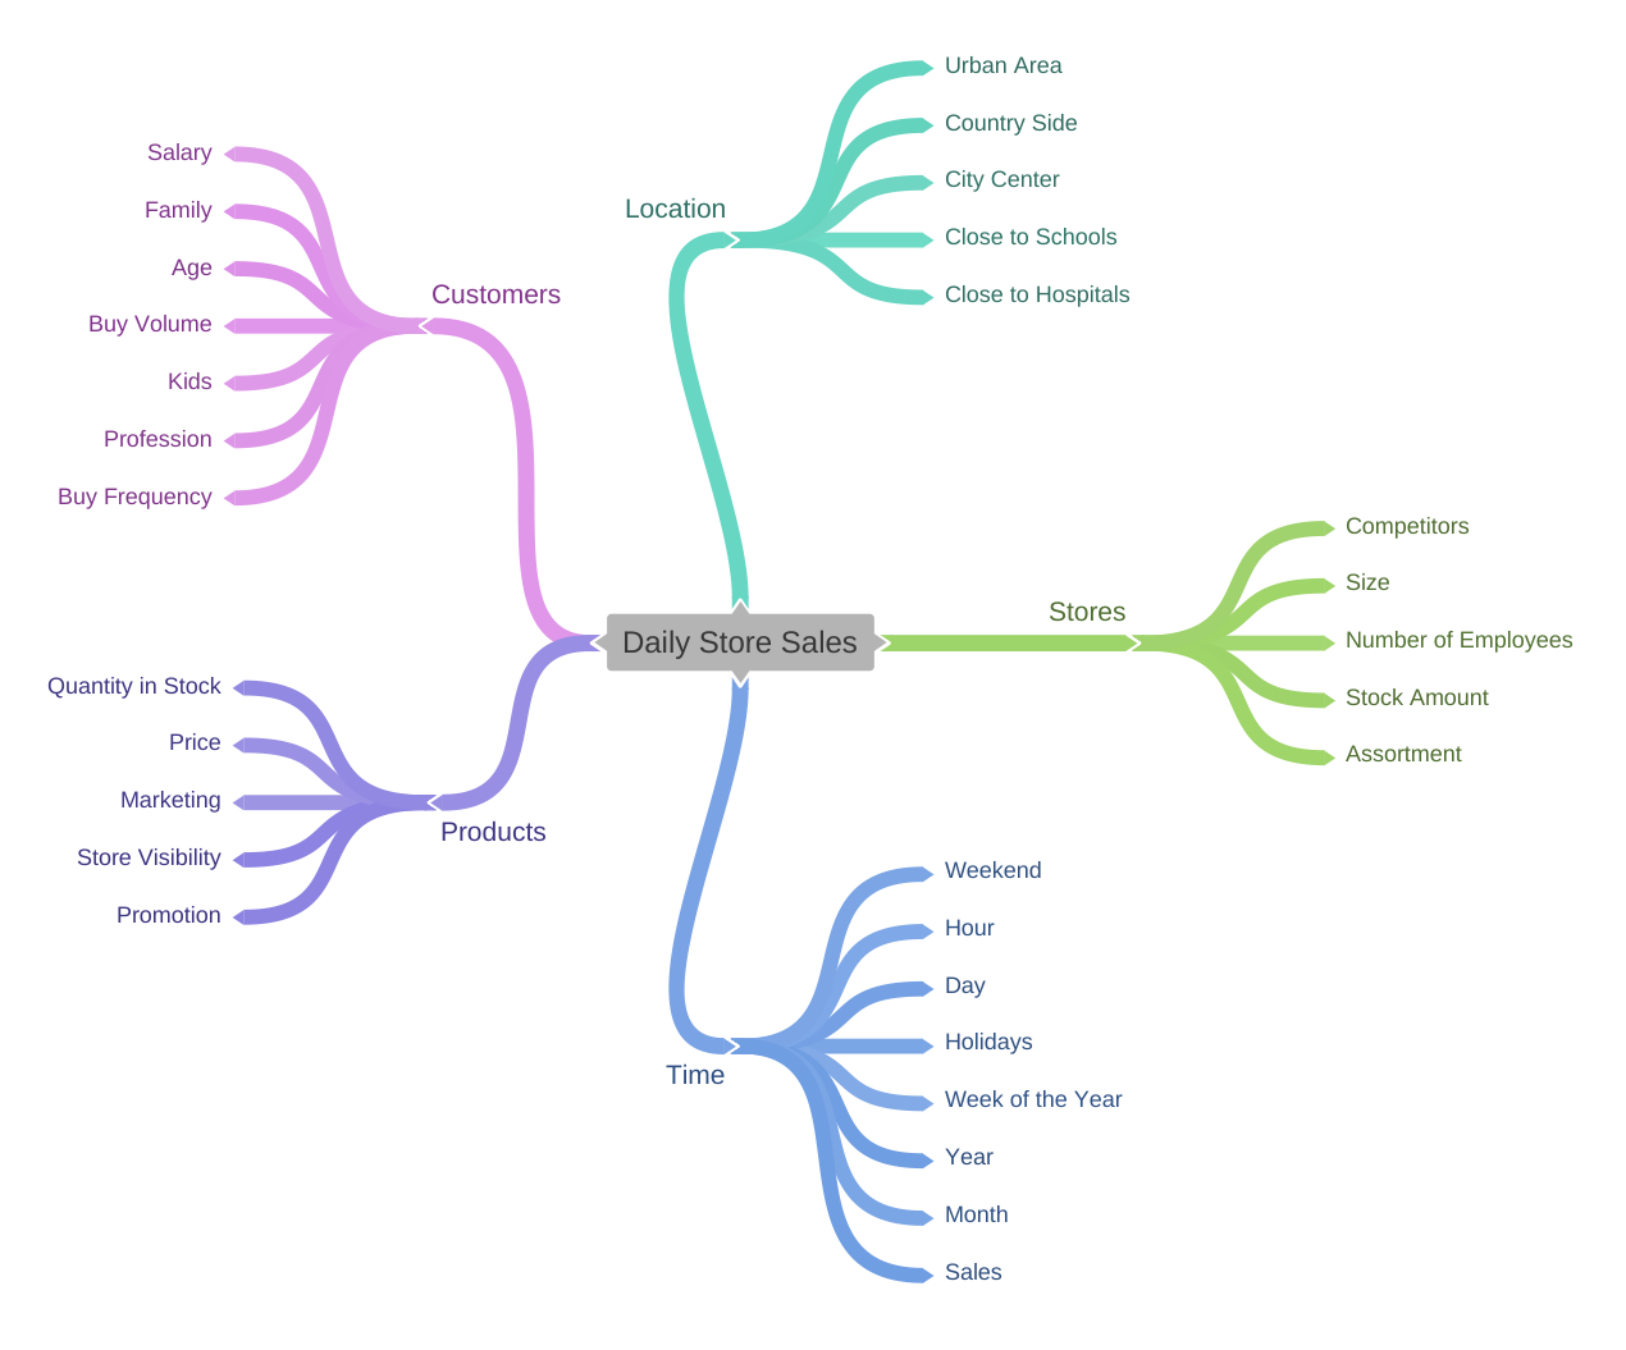

In [17]:
Image('img/mental_map.png')

## 2.2 Hyphotesis Creation

### 2.2.1 - Store's Hypothesis

**1.** Lojas com número maior de funcionários deveriam vender mais.

**2.** Lojas com maior capacidade de estoque deveriam vender mais.

**3.** Lojas com maior porte deveriam vender mais.

**4.** Lojas com maior sortimento deveriam vender mais.

**5.** Lojas com competidores mais próximos deveriam vender menos.

**6.** Lojas com competidores a mais tempo deveriam vender mais.

### 2.2.2 - Products's Hypothesis

**1.** Lojas que investem mais em marketing deveriam vender mais.

**2.** Lojas com maior exposição de produtos deveriam vender mais.

**3.** Lojas com produtos com preço menor deveriam vender mais.

**4.** Lojas com promoções mais agressivas (descontos maiores) deveriam vender mais.

**5.** Lojas com promoções ativas por mais tempo deveriam vender mais.

**6.** Lojas com mais dias de promoção deveriam vender mais.

**7.** Lojas com mais promoções consecutivas deveriam vender mais.

### 2.2.3 - Time's Hypothesis

**1.** Lojas abertas durante o feriado de Natal deveriam vender mais.

**2.** Lojas deveriam vender mais ao longo dos anos.

**3.** Lojas deveriam vender mais no segundo semestre do ano.

**4.** Lojas deveriam vender mais depois do dia 10 de cada mês.

**5.** Lojas deveriam vender menos aos finais de semana.

**6.** Lojas deveriam vender menos durante os feriados escolares.

## 2.3 Final List of Hyphotesis

**1.** Lojas com maior sortimento deveriam vender mais.

**2.** Lojas com competidores mais próximos deveriam vender menos.

**3.** Lojas com competidores a mais tempo deveriam vender mais.

**4.** Lojas com promoções ativas por mais tempo deveriam vender mais.

**5.** Lojas com mais dias de promoção deveriam vender mais.

**6.** Lojas com mais promoções consecutivas deveriam vender mais.

**7.** Lojas abertas durante o feriado de Natal deveriam vender mais.

**8.** Lojas deveriam vender mais ao longo dos anos.

**9.** Lojas deveriam vender mais no segundo semestre do ano.

**10.** Lojas deveriam vender mais depois do dia 10 de cada mês.

**11.** Lojas deveriam vender menos aos finais de semana.

**12.** Lojas deveriam vender menos durante os feriados escolares.

## 2.4 Feature Engineering

In [18]:
# year

df2['year'] = df2['date'].dt.year

# month

df2['month'] = df2['date'].dt.month

# day

df2['day'] = df2['date'].dt.day

# week_of_year

df2['week_of_year'] = df2['date'].dt.weekofyear

# year_week

df2['year_week'] = df2['date'].dt.strftime('%Y-%W')

# competition_since

df2['competition_since'] = df2.apply(lambda x: datetime.datetime(year = x['competition_open_since_year'], month = x['competition_open_since_month'], day = 1), axis = 1)
df2['competition_time_month'] = ((df2['date'] - df2['competition_since']) / 30).apply(lambda x: x.days).astype(int)

# promo_since

df2['promo_since'] = df2['promo2_since_year'].astype(str) + '-' + df2['promo2_since_week'].astype(str)
df2['promo_since'] = df2['promo_since'].apply(lambda x: datetime.datetime.strptime(x + '-1', '%Y-%W-%w') - datetime.timedelta(days = 7))
df2['promo_time_week'] = ((df2['date'] - df2['promo_since']) / 7).apply(lambda x: x.days).astype(int)

# assortment

df2['assortment'] = df2['assortment'].apply(lambda x: 'basic' if x == 'a' else 'extra' if x == 'b' else 'extended')

# state_holiday

df2['state_holiday'] = df2['state_holiday'].apply(lambda x: 'public_holiday' if x == 'a' else 'easter_holiday' if x == 'b' else 'christmas' if x == 'c' else 'regular_day')

In [19]:
df2.head().T

,0,1,2,3,4
store,1,2,3,4,5
day_of_week,5,5,5,5,5
date,2015-07-31 00:00:00,2015-07-31 00:00:00,2015-07-31 00:00:00,2015-07-31 00:00:00,2015-07-31 00:00:00
sales,5263,6064,8314,13995,4822
customers,555,625,821,1498,559
open,1,1,1,1,1
promo,1,1,1,1,1
state_holiday,regular_day,regular_day,regular_day,regular_day,regular_day
school_holiday,1,1,1,1,1
store_type,c,a,a,c,a


# 3.0 FEATURE FILTERING

In [20]:
df3 = df2.copy()

In [21]:
df3.head()

,store,day_of_week,date,sales,customers,open,promo,state_holiday,school_holiday,store_type,assortment,competition_distance,competition_open_since_month,competition_open_since_year,promo2,promo2_since_week,promo2_since_year,promo_interval,month_map,is_promo,year,month,day,week_of_year,year_week,competition_since,competition_time_month,promo_since,promo_time_week
0,1,5,2015-07-31,5263,555,1,1,regular_day,1,c,basic,1270.0,9,2008,0,31,2015,0,Jul,0,2015,7,31,31,2015-30,2008-09-01,84,2015-07-27,0
1,2,5,2015-07-31,6064,625,1,1,regular_day,1,a,basic,570.0,11,2007,1,13,2010,"Jan,Apr,Jul,Oct",Jul,1,2015,7,31,31,2015-30,2007-11-01,94,2010-03-22,279
2,3,5,2015-07-31,8314,821,1,1,regular_day,1,a,basic,14130.0,12,2006,1,14,2011,"Jan,Apr,Jul,Oct",Jul,1,2015,7,31,31,2015-30,2006-12-01,105,2011-03-28,226
3,4,5,2015-07-31,13995,1498,1,1,regular_day,1,c,extended,620.0,9,2009,0,31,2015,0,Jul,0,2015,7,31,31,2015-30,2009-09-01,71,2015-07-27,0
4,5,5,2015-07-31,4822,559,1,1,regular_day,1,a,basic,29910.0,4,2015,0,31,2015,0,Jul,0,2015,7,31,31,2015-30,2015-04-01,4,2015-07-27,0


## 3.1 Rows Filtering

In [22]:
df3 = df3[(df3['open'] != 0) & (df3['sales'] > 0)]

## 3.1 Cols Selection

In [23]:
cols_drop = ['customers', 'open', 'promo_interval', 'month_map']

df3 = df3.drop(cols_drop, axis = 1)

df3.columns

Index(['store', 'day_of_week', 'date', 'sales', 'promo', 'state_holiday',
       'school_holiday', 'store_type', 'assortment', 'competition_distance',
       'competition_open_since_month', 'competition_open_since_year', 'promo2',
       'promo2_since_week', 'promo2_since_year', 'is_promo', 'year', 'month',
       'day', 'week_of_year', 'year_week', 'competition_since',
       'competition_time_month', 'promo_since', 'promo_time_week'],
      dtype='object')

# 4.0 EXPLORATORY DATA ANALYSIS

In [24]:
df4 = df3.copy()

## 4.1 Univariate Analysis

### 4.1.1 Response Variable

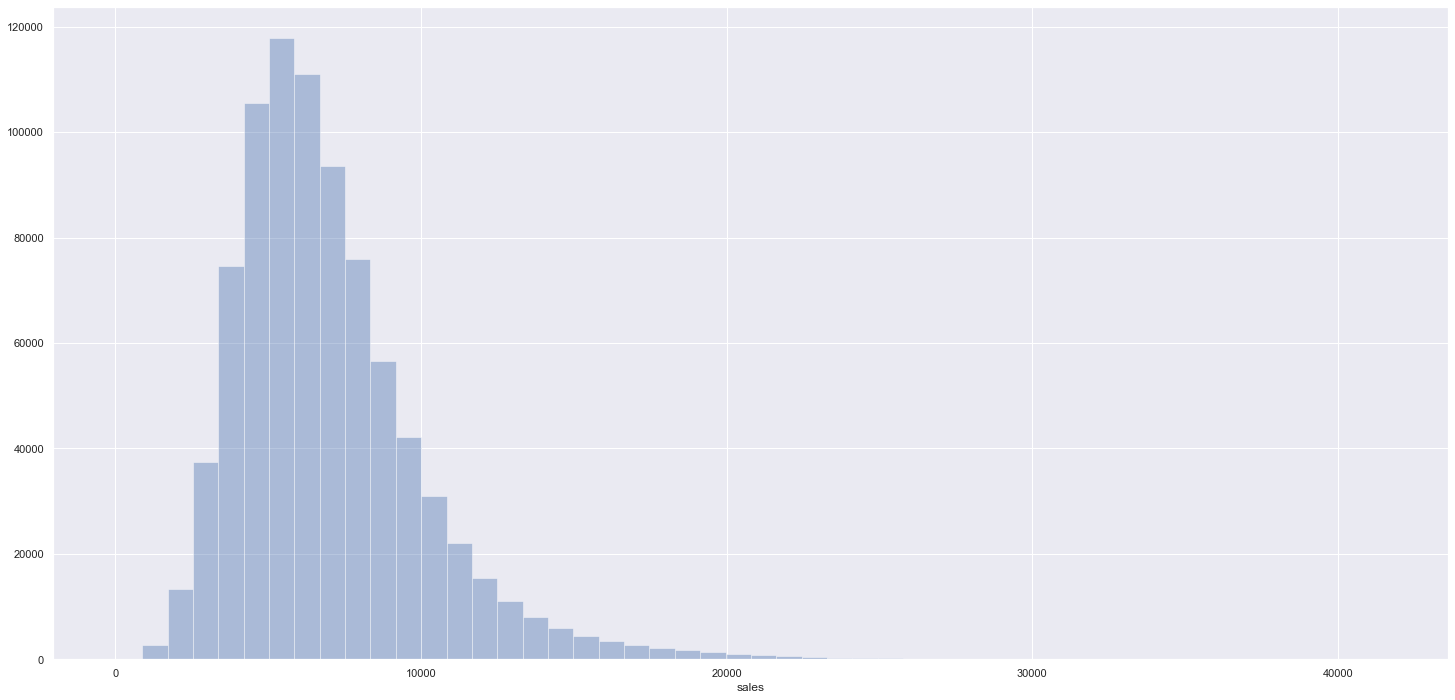

In [25]:
sns.distplot(df4['sales'], kde = False);

### 4.1.2 Numerical Variables

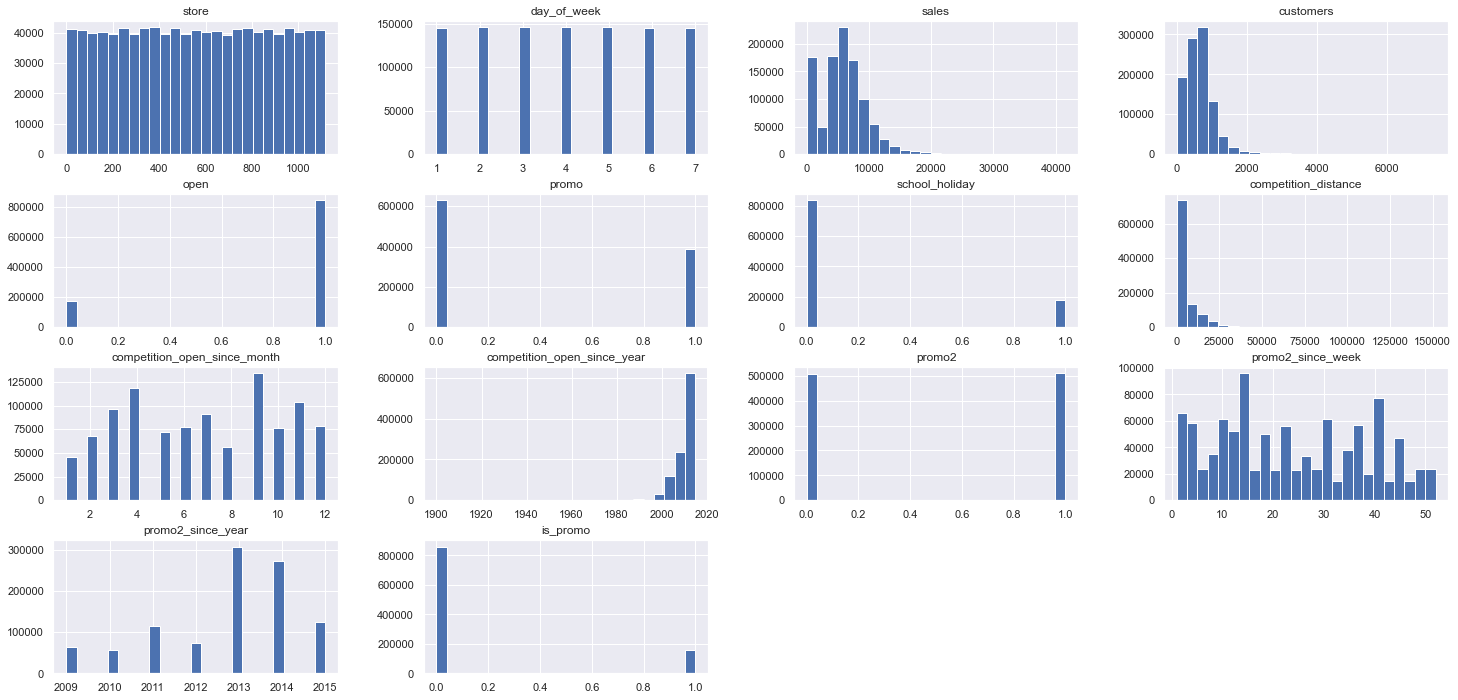

In [26]:
num_att.hist(bins = 25);

### 4.1.3 Categorical Variables

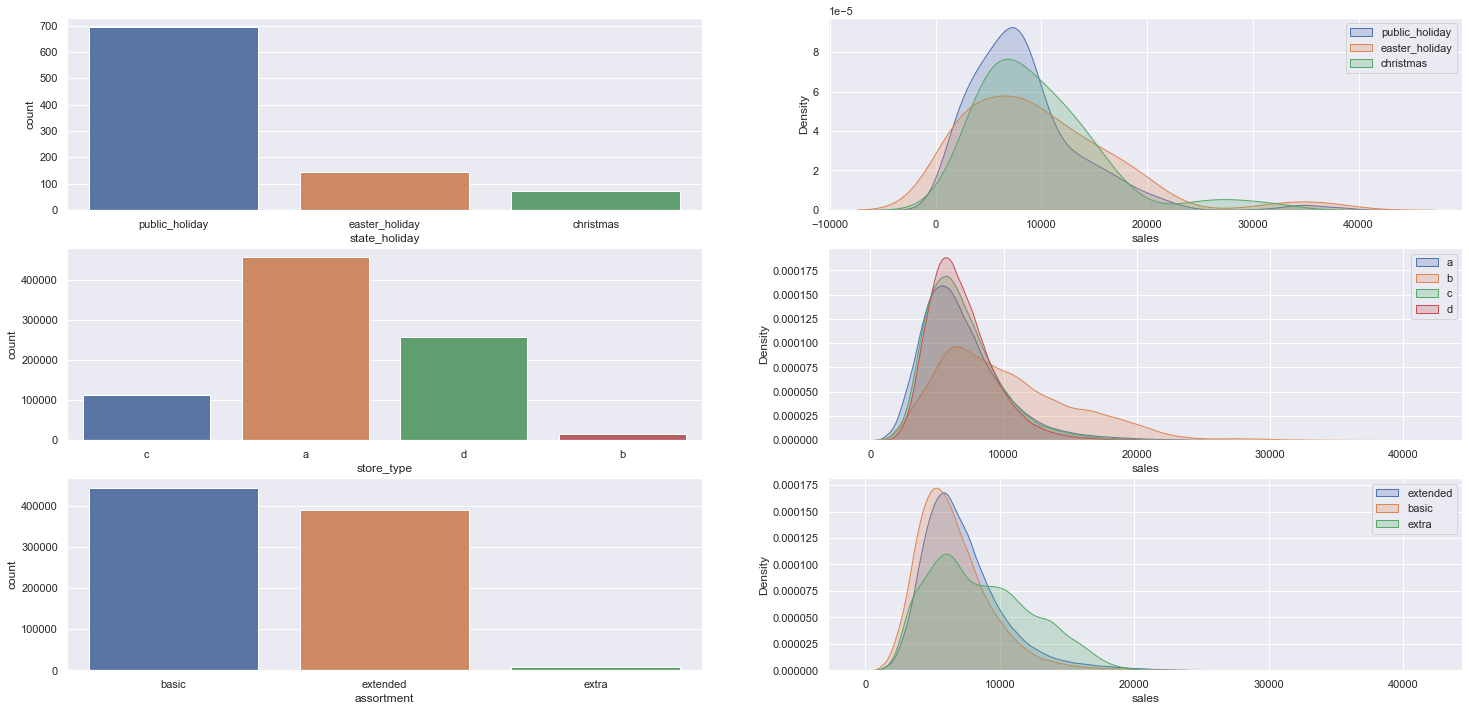

In [27]:
# state_holiday

plt.subplot(3, 2, 1)
a = df4[df4['state_holiday'] != 'regular_day']
sns.countplot(a['state_holiday'])

plt.subplot(3, 2, 2)
sns.kdeplot(df4[df4['state_holiday'] == 'public_holiday']['sales'], shade = True, label ='public_holiday' )
sns.kdeplot(df4[df4['state_holiday'] == 'easter_holiday']['sales'], shade = True, label ='easter_holiday' )
sns.kdeplot(df4[df4['state_holiday'] == 'christmas']['sales'], shade = True, label ='christmas' )
plt.legend()

# store_type

plt.subplot(3, 2, 3)
sns.countplot(df4['store_type'])

plt.subplot(3, 2, 4)
sns.kdeplot(df4[df4['store_type'] == 'a']['sales'], shade = True, label = 'a')
sns.kdeplot(df4[df4['store_type'] == 'b']['sales'], shade = True, label = 'b')
sns.kdeplot(df4[df4['store_type'] == 'c']['sales'], shade = True, label = 'c')
sns.kdeplot(df4[df4['store_type'] == 'd']['sales'], shade = True, label = 'd')
plt.legend()

# assortment

plt.subplot(3, 2, 5)
sns.countplot(df4['assortment'])

plt.subplot(3, 2, 6)
sns.kdeplot(df4[df4['assortment'] == 'extended']['sales'], shade = True, label = 'extended')
sns.kdeplot(df4[df4['assortment'] == 'basic']['sales'], shade = True, label = 'basic')
sns.kdeplot(df4[df4['assortment'] == 'extra']['sales'], shade = True, label = 'extra')
plt.legend();

## 4.2 Bivariate Analysis

**1.** Stores with bigger assortment should sell more.

**2.** Stores closer to competitors should sell less.

**3.** Stores that have competition for longer time should sell more.

**4.** Stores that have active promotions for longer periods should sell more.

**5.** Stores with more promotion days should sell more.

**6.** Stores with more consecutive promotions should sell more.

**7.** Stores opened during Christmas Holiday should sell more.

**8.** Stores should sell more over the years.

**9.** Stores should sell more during the second semester of the year.

**10.** Stores should sell more after the 15th day of each month.

**11.** Stores should sell less during the weekends.

**12.** Stores should sell more during the school holidays.

### H1. Stores with bigger assortment should sell more.
**REFUSED** - Stores with bigger assortment sell less.

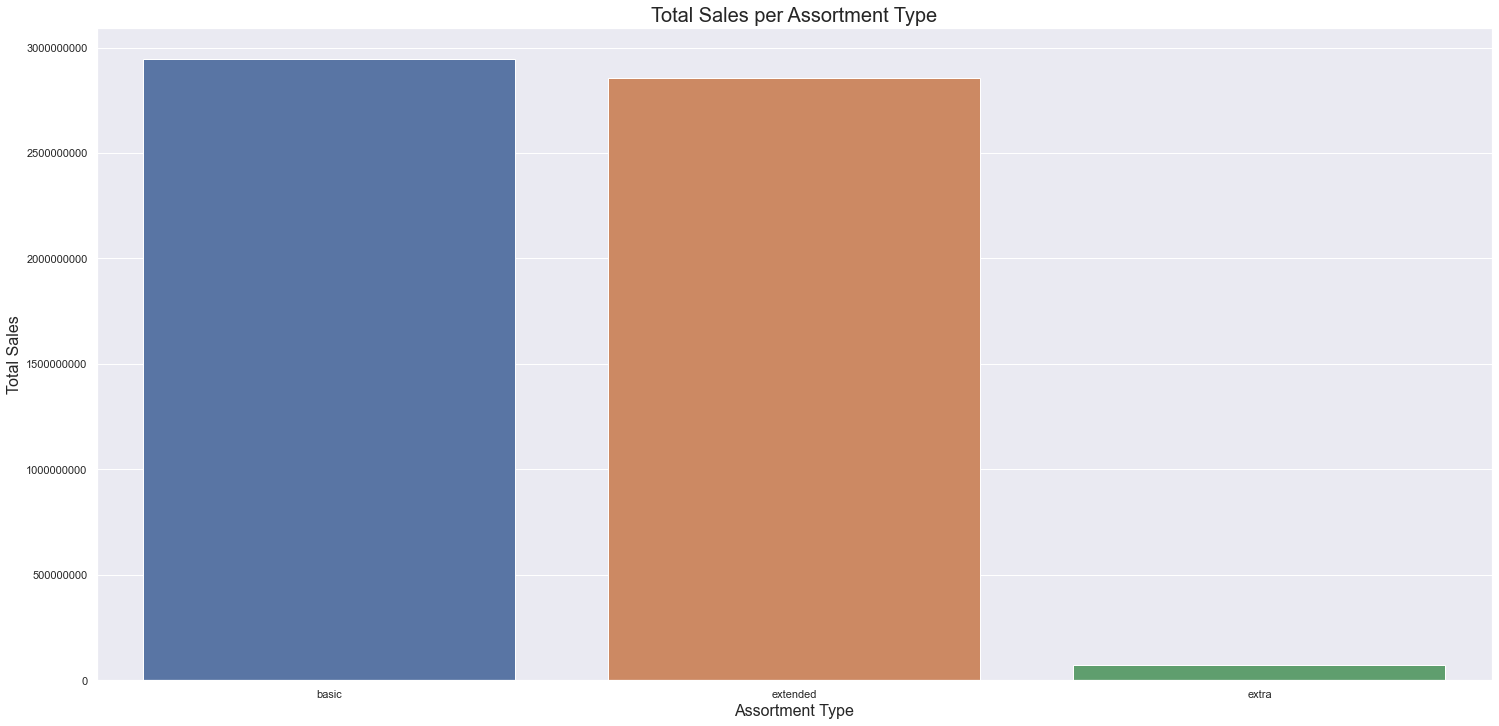

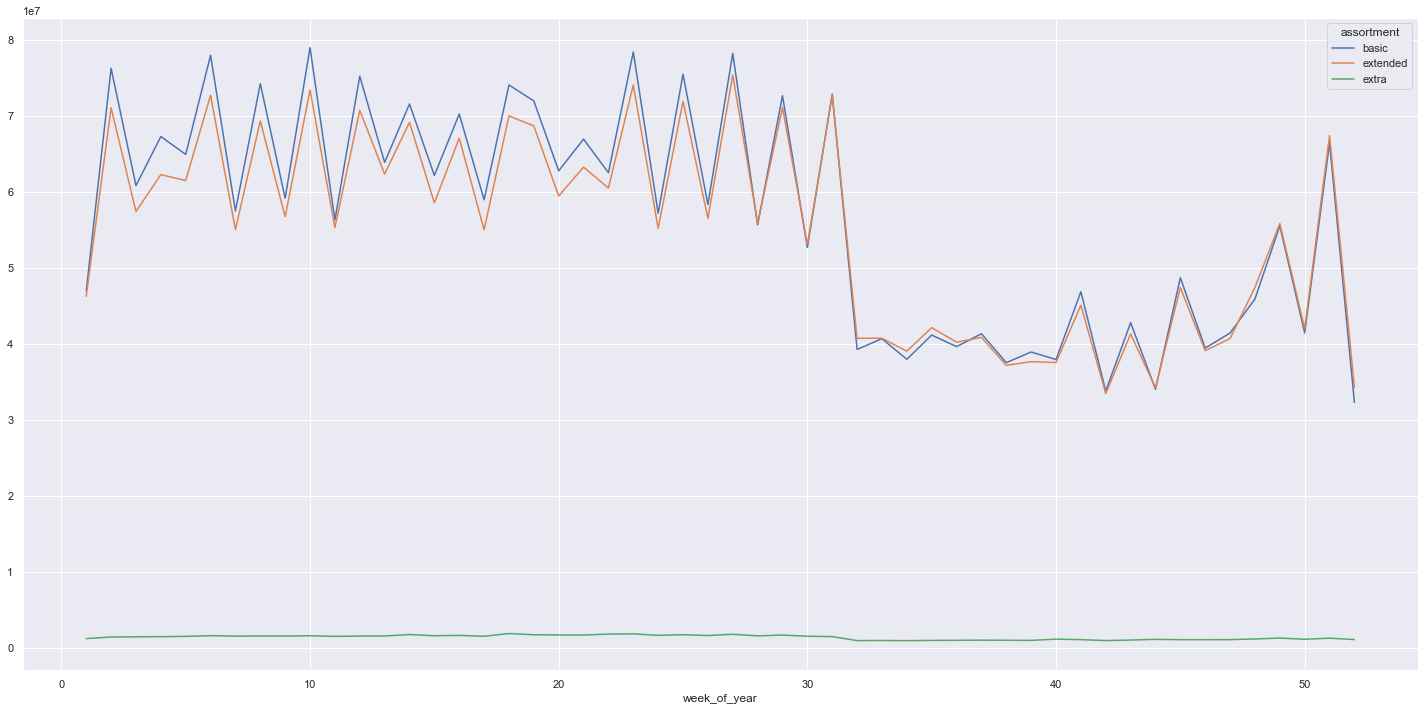

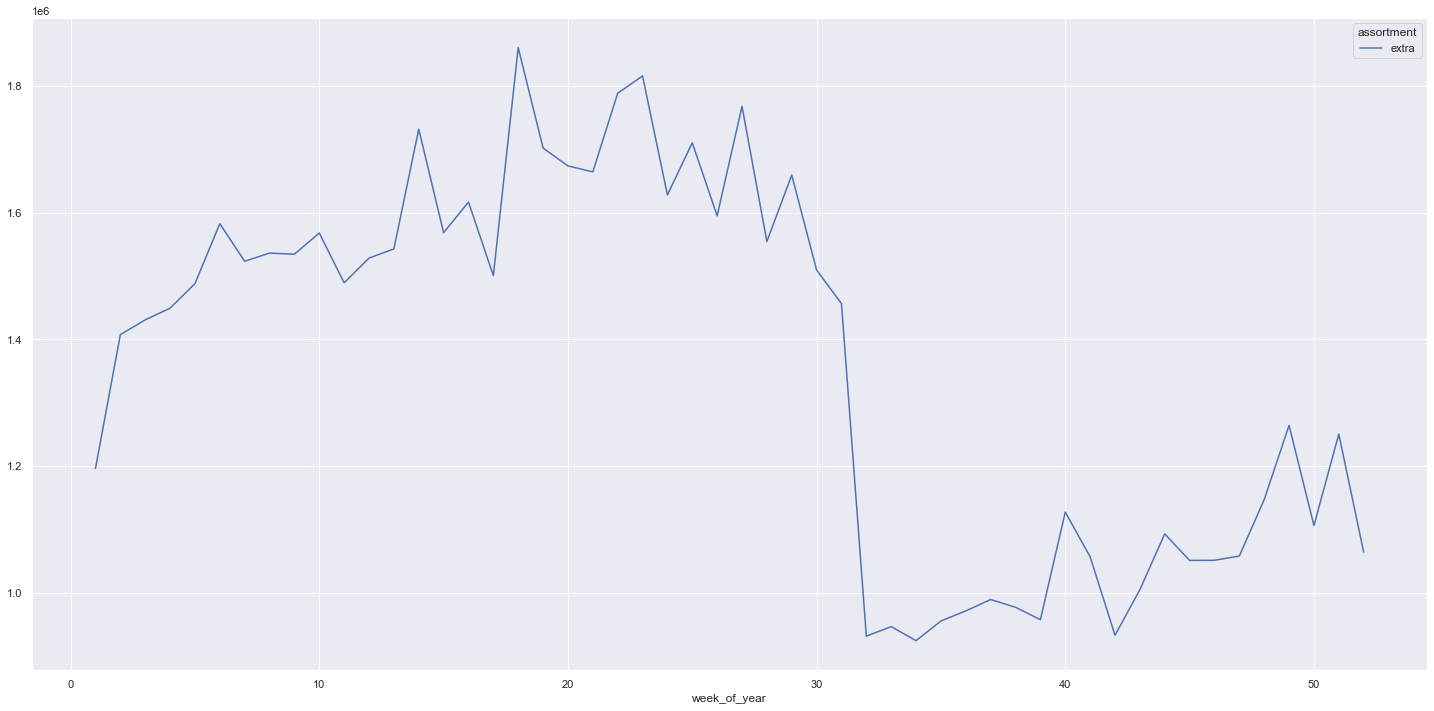

In [28]:
aux1 = df4[['assortment', 'sales']].groupby('assortment').sum().reset_index()
sns.barplot(x = 'assortment', y = 'sales', data = aux1);
plt.ticklabel_format(style='plain', axis='y')
plt.title('Total Sales per Assortment Type', size = 20)
plt.xlabel('Assortment Type', size = 16)
plt.ylabel('Total Sales', size = 16)

aux2 = df4[['week_of_year', 'assortment', 'sales']].groupby(['week_of_year','assortment']).sum().reset_index()
aux2.pivot(index = 'week_of_year', columns = 'assortment', values = 'sales').plot()

aux3 = aux2[aux2['assortment'] == 'extra']
aux3.pivot(index = 'week_of_year', columns = 'assortment', values = 'sales').plot();

### H2. Stores closer to competitors should sell less.
**REFUSED** - Stores closer to competitors sell more.

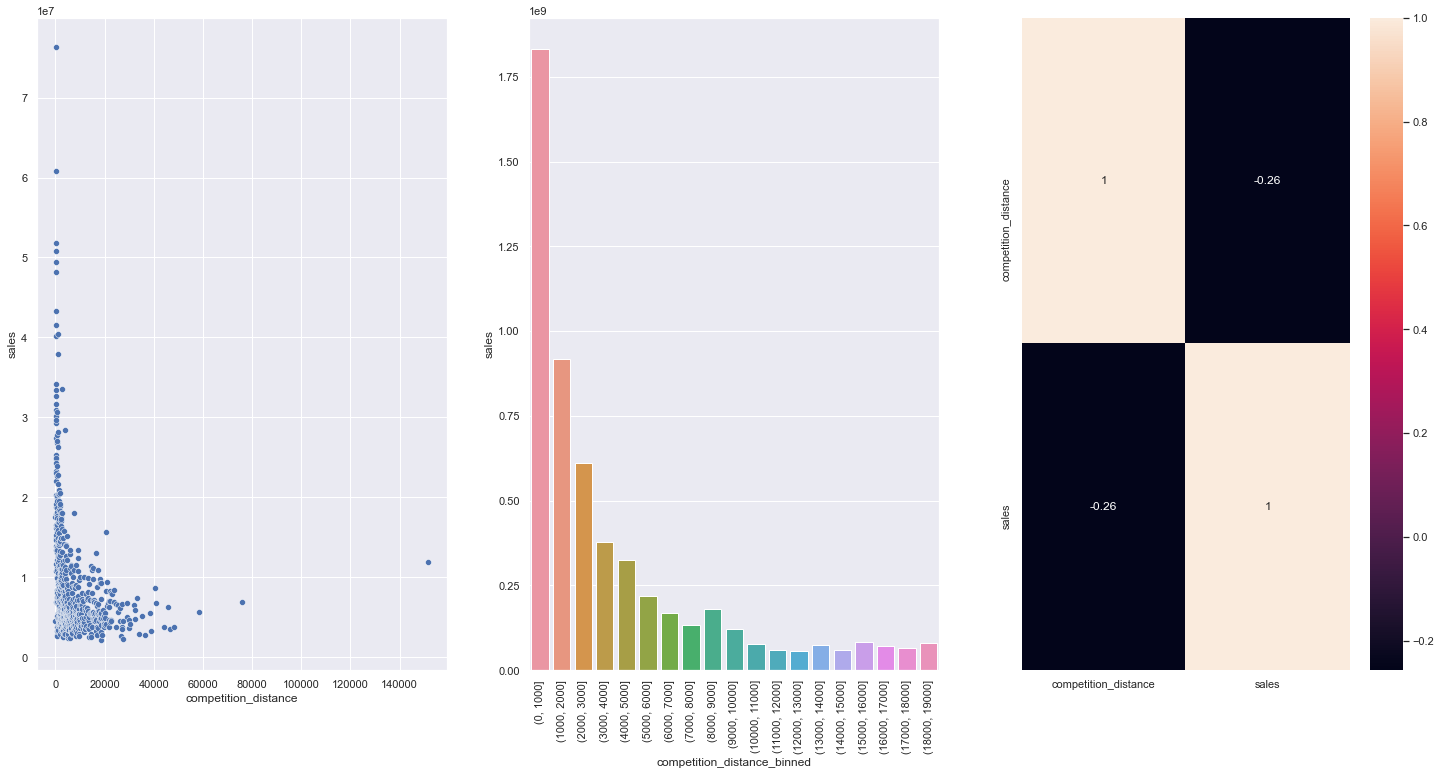

In [29]:
aux1 = df4[['competition_distance', 'sales']].groupby('competition_distance').sum().reset_index()

plt.subplot(1, 3, 1)
sns.scatterplot(x = 'competition_distance', y = 'sales', data = aux1);

plt.subplot(1, 3, 2)
bins = list(np.arange(0, 20000, 1000))
aux1['competition_distance_binned'] = pd.cut(aux1['competition_distance'], bins = bins)
aux2 = aux1[['competition_distance_binned', 'sales']].groupby('competition_distance_binned').sum().reset_index()
sns.barplot(x = 'competition_distance_binned', y = 'sales', data = aux2)
plt.xticks(rotation = 90)

plt.subplot(1, 3, 3)
sns.heatmap(aux1.corr(method = 'pearson'), annot = True);

### H3. Stores that have competition for longer time should sell more.
**REFUSED** - Stores that have competition for longer time sell less.

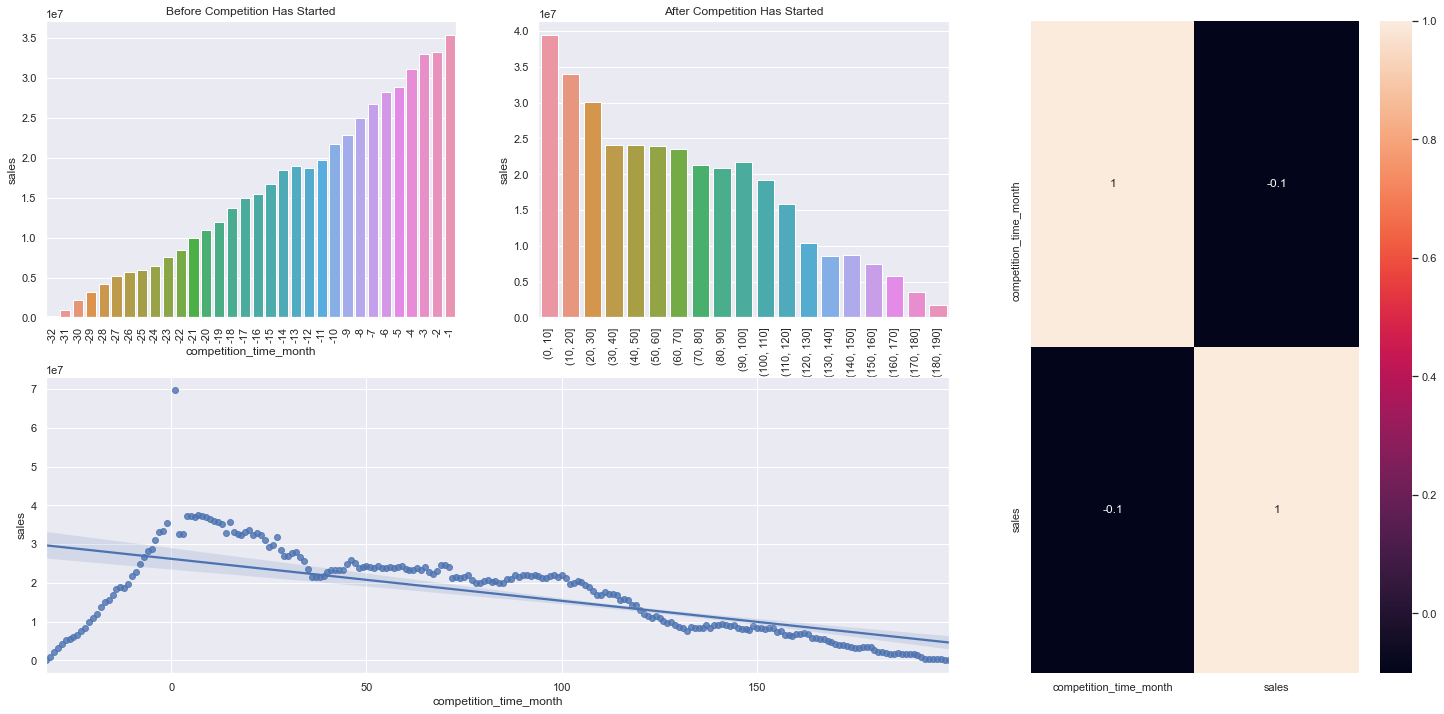

In [30]:
grid = GridSpec( 2, 3 )
aux1 = df4[['competition_time_month', 'sales']].groupby('competition_time_month').sum().reset_index()

# before competition starts

plt.subplot(grid[0,0])
aux2 = aux1[aux1['competition_time_month'] < 0]
sns.barplot(x = 'competition_time_month', y = 'sales', data = aux2);
plt.xticks(rotation = 90);
plt.title('Before Competition Has Started')

# after competition started

plt.subplot(grid[0,1])
bins = list(np.arange(0,200, 10))
aux3 = aux1[aux1['competition_time_month'] > 0]
aux3['competition_time_month_binned'] = pd.cut(aux3['competition_time_month'], bins = bins)
sns.barplot(x = 'competition_time_month_binned', y = 'sales', data = aux3, ci = None);
plt.xticks(rotation = 90)
plt.title('After Competition Has Started')

# regression and correlation

plt.subplot(grid[1,:2])
aux4 = aux1[(aux1['competition_time_month'] != 0) & (aux1['competition_time_month'] < 200)]
sns.regplot(x = 'competition_time_month', y = 'sales', data = aux4)

plt.subplot(grid[:2,2])
sns.heatmap(aux1.corr(), annot = True);

### H4. Stores that have active promotions for longer periods should sell more.
**REFUSED** - Stores that have active promotions for longer periods sell less.

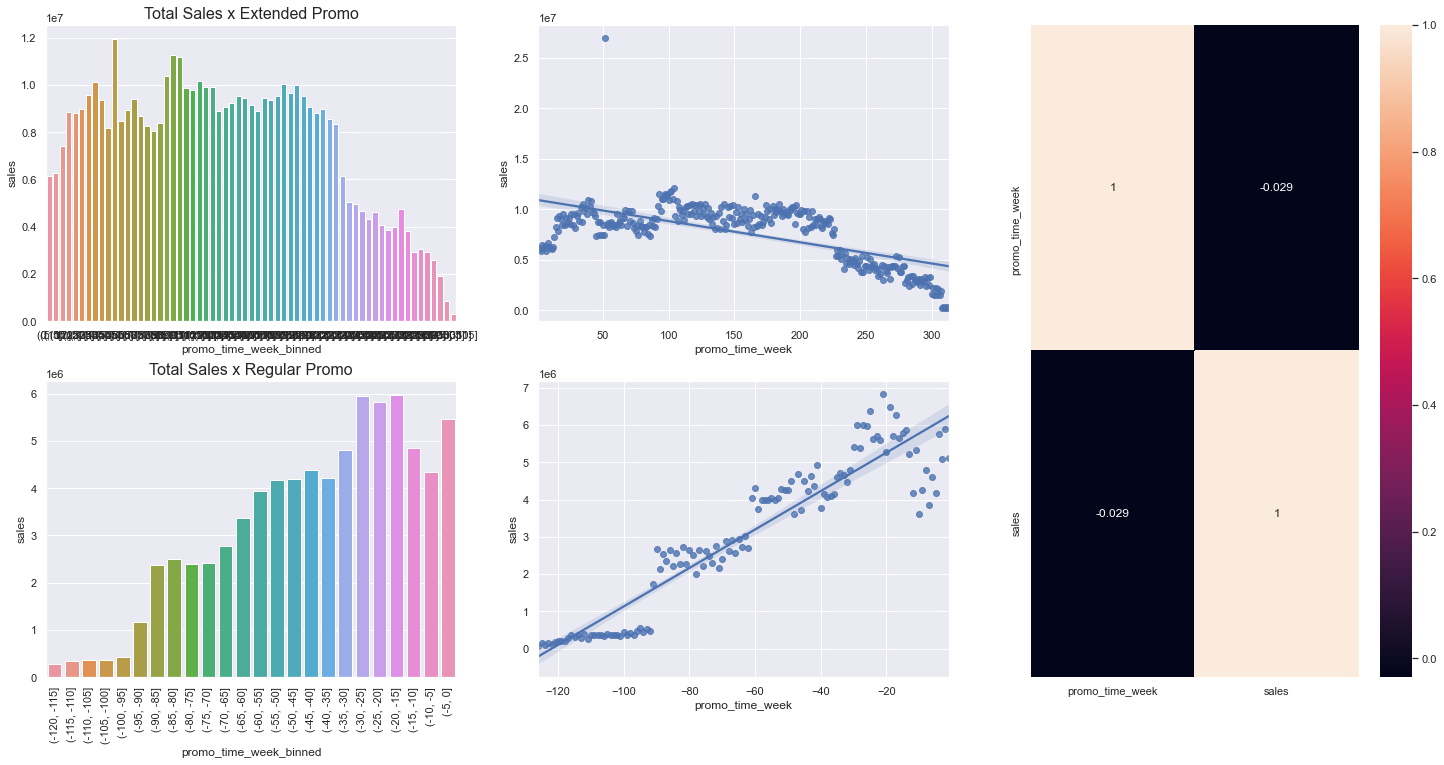

In [31]:
aux1 = df4[['promo_time_week', 'sales']].groupby('promo_time_week').sum().reset_index()

grid = GridSpec(2, 3)

plt.subplot(grid[0, 0])
bins = list(np.arange(0,320, 5))
aux2 = aux1[aux1['promo_time_week'] > 0] # extended promo
aux2['promo_time_week_binned'] = pd.cut(aux2['promo_time_week'], bins = bins)
sns.barplot(x = 'promo_time_week_binned', y = 'sales', data = aux2, ci = None)
plt.title('Total Sales x Extended Promo', size = 16)

plt.subplot(grid[0, 1])
sns.regplot(x = 'promo_time_week', y = 'sales', data = aux2)

plt.subplot(grid[1, 0])
bins = list(np.arange(-120, 5, 5))
aux3 = aux1[aux1['promo_time_week'] < 0] # regular promo
aux3['promo_time_week_binned'] = pd.cut(aux3['promo_time_week'], bins = bins)
sns.barplot(x = 'promo_time_week_binned', y = 'sales', data = aux3, ci = None)
plt.title('Total Sales x Regular Promo', size = 16)
plt.xticks(rotation = 90)

plt.subplot(grid[1, 1])
sns.regplot(x = 'promo_time_week', y = 'sales', data = aux3)

plt.subplot(grid[:, 2])
sns.heatmap(aux1.corr(method = 'pearson'), annot = True);

### <s>H5. Stores with more promotion days should sell more.</s>
**FUTURE ANALYSIS**

### H6. Stores with more consecutive promotions should sell more
**REFUSED** - Stores with more consecutive promotions sell less.

In [32]:
df4[['promo', 'promo2', 'sales']].groupby(['promo', 'promo2']).sum().reset_index()

,promo,promo2,sales
0,0,0,1482612096
1,0,1,1289362241
2,1,0,1628930532
3,1,1,1472275754


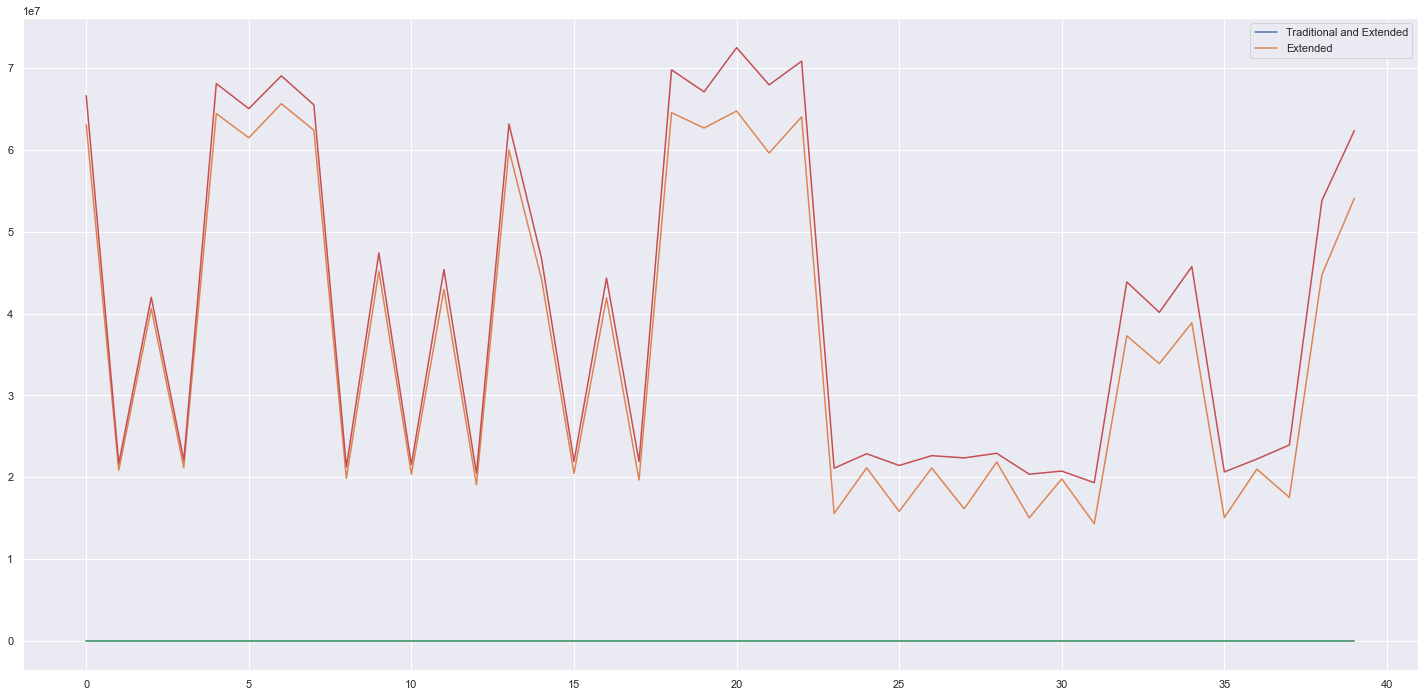

In [33]:
aux1 = df4[(df4['promo'] == 1) & (df4['promo2'] == 1)][['week_of_year', 'sales']].groupby('week_of_year').sum().reset_index()
ax = aux1.plot();

aux2 = df4[(df4['promo'] == 1) & (df4['promo2'] == 0)][['week_of_year', 'sales']].groupby('week_of_year').sum().reset_index()
aux2.plot(ax = ax)

ax.legend(labels = ['Traditional and Extended', 'Extended']);

### H7. Stores opened during the Christmas Holiday should sell more.
**REFUSED** - Stores opened during the Christmas Holiday sell less.

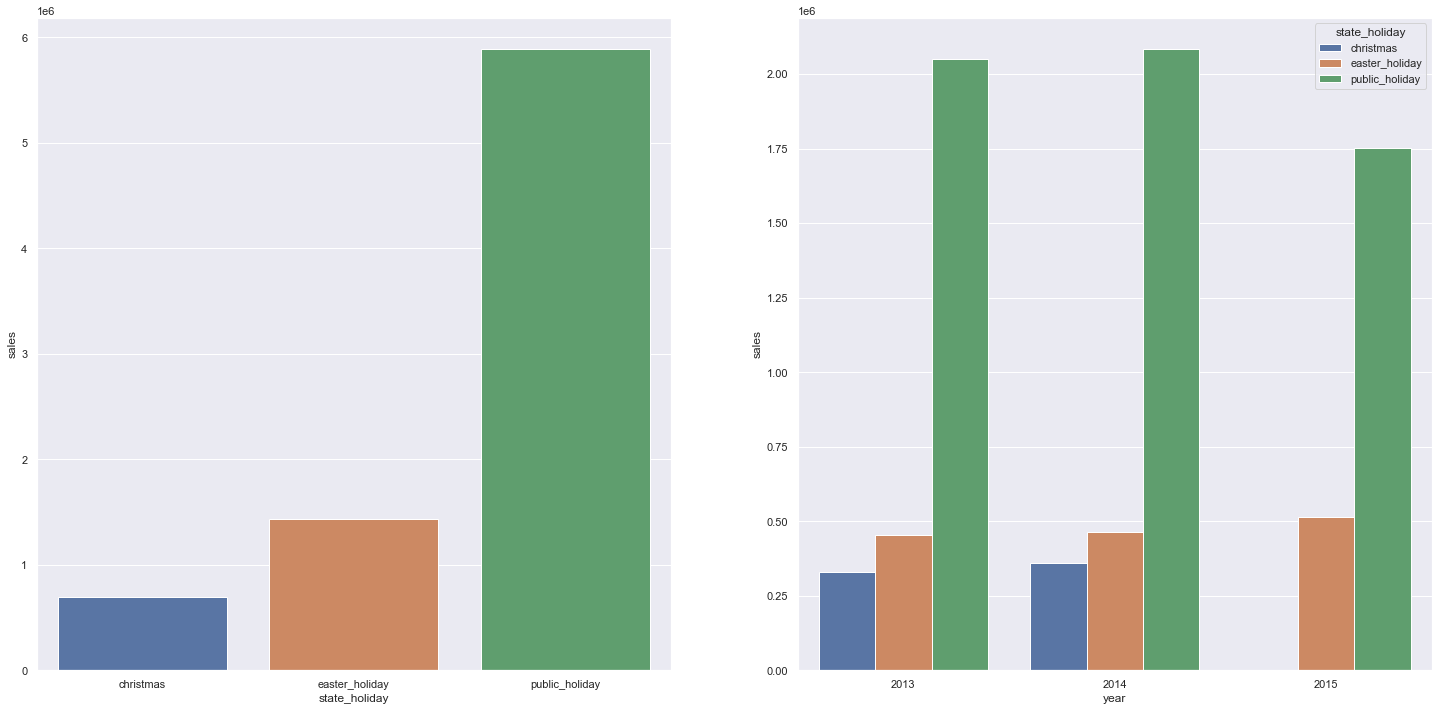

In [34]:
aux = df4[df4['state_holiday'] != 'regular_day']

plt.subplot(1, 2, 1)
aux1 = aux[['state_holiday', 'sales']].groupby('state_holiday').sum().reset_index()
sns.barplot(x = 'state_holiday', y = 'sales', data = aux1);

plt.subplot(1, 2, 2)
aux2 = aux[['year', 'state_holiday', 'sales']].groupby(['year', 'state_holiday']).sum().reset_index()
sns.barplot(x = 'year', y = 'sales', hue = 'state_holiday', data = aux2);

### H8 Lojas deveriam vender mais ao longo dos anos.
**FALSE** - Lojas vendem menos ao longo dos anos.

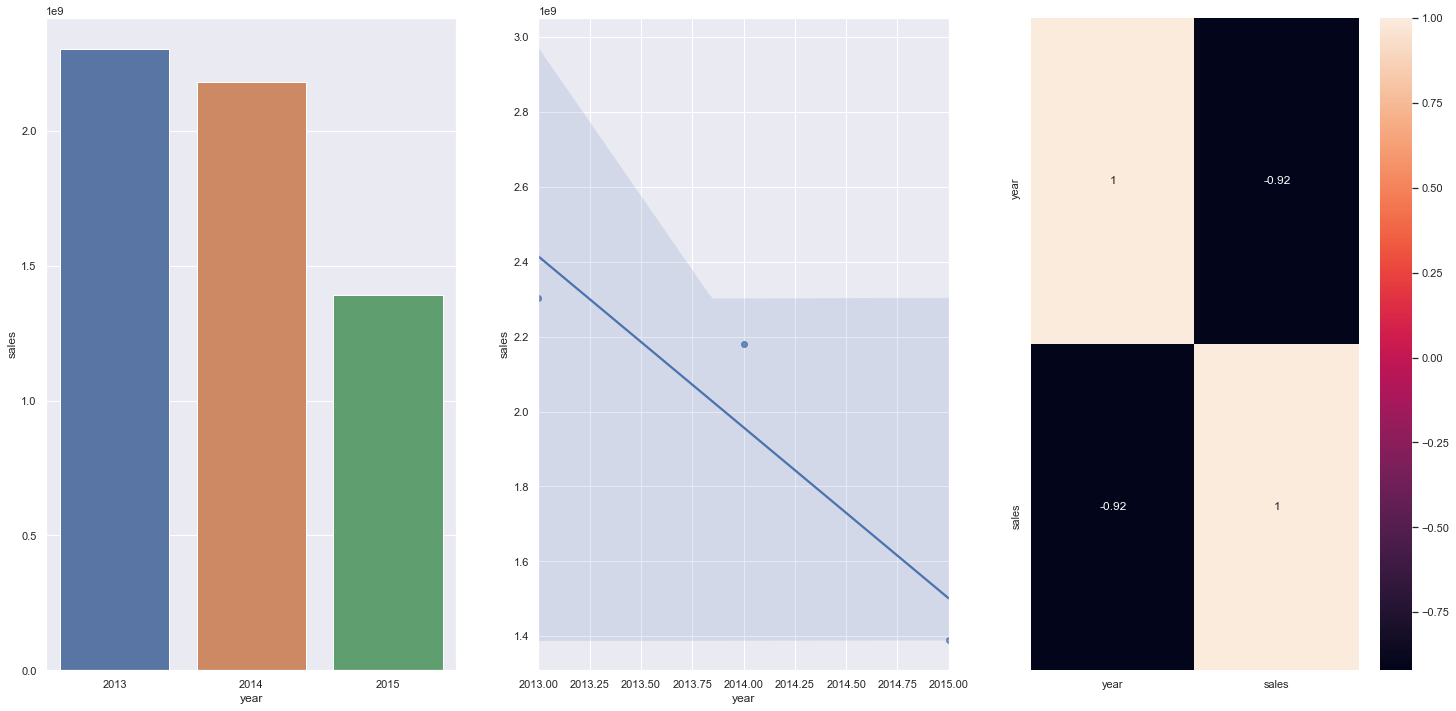

In [35]:
aux1 = df4[['year', 'sales']].groupby('year').sum().reset_index()

plt.subplot(1, 3, 1)
sns.barplot(x = 'year', y = 'sales', data = aux1)

plt.subplot(1, 3, 2)
sns.regplot(x = 'year', y = 'sales', data = aux1)

plt.subplot(1, 3, 3)
sns.heatmap(aux1.corr(method = 'pearson'), annot = True);

### H9. Stores should sell more during the second semester of the year.
**REFUSED** - Stores sell less during the second semester of the year.

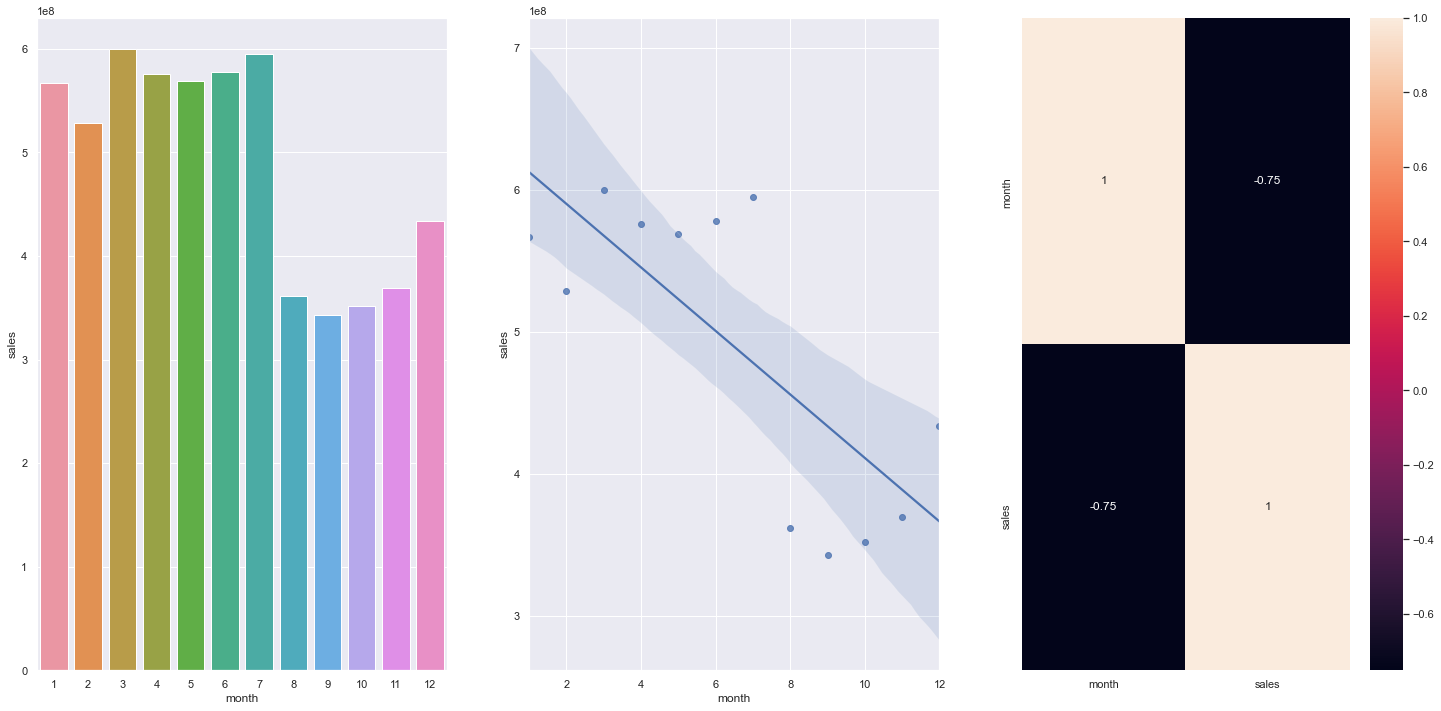

In [36]:
aux1 = df4[['month', 'sales']].groupby('month').sum().reset_index()

plt.subplot(1, 3, 1)
sns.barplot(x = 'month', y = 'sales', data = aux1)

plt.subplot(1, 3, 2)
sns.regplot(x = 'month', y = 'sales', data = aux1)

plt.subplot(1, 3, 3)
sns.heatmap(aux1.corr(method = 'pearson'), annot = True);

### H10. Stores should sell more after the 15th day of the month.
**TRUE** - Stores sell more after the 15th day of the month.

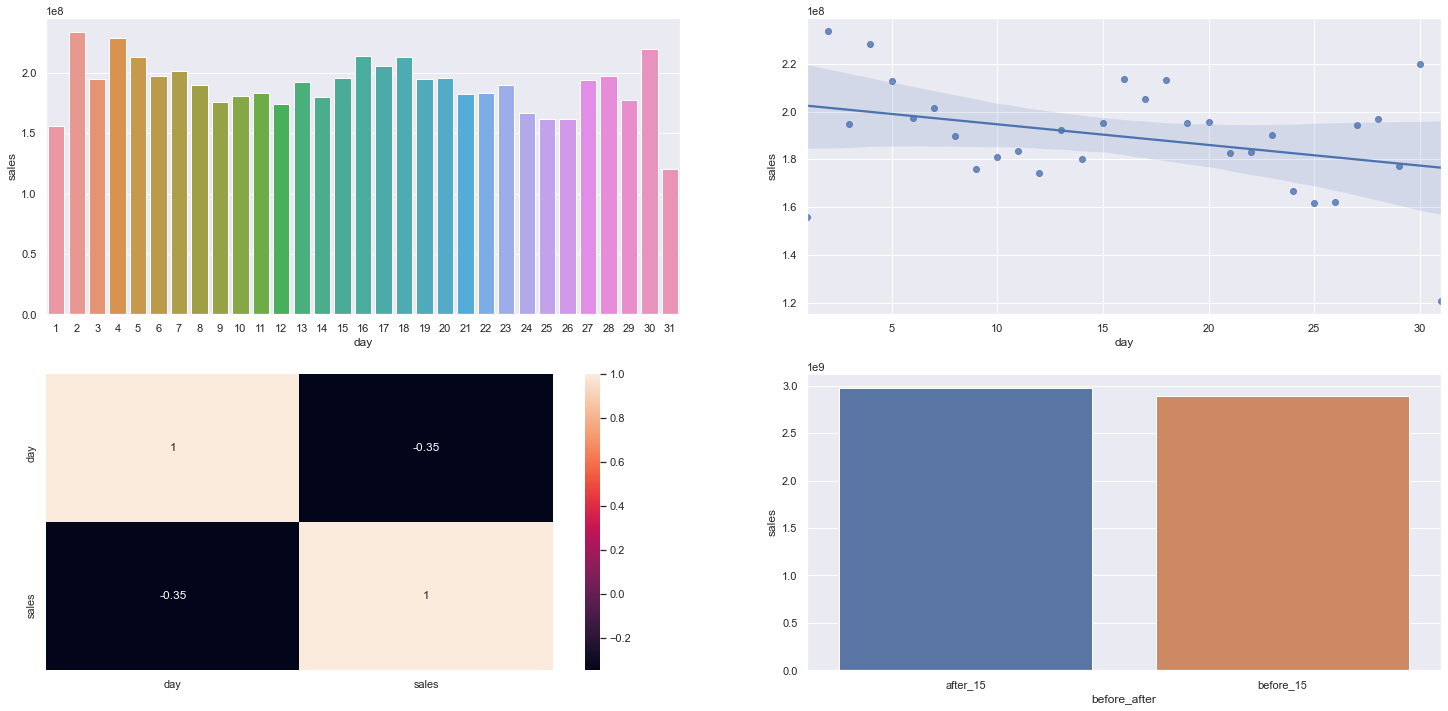

In [37]:
aux1 = df4[['day', 'sales']].groupby('day').sum().reset_index()

plt.subplot(2, 2, 1)
sns.barplot(x = 'day', y = 'sales', data = aux1)

plt.subplot(2, 2, 2)
sns.regplot(x = 'day', y = 'sales', data = aux1)

plt.subplot(2, 2, 3)
sns.heatmap(aux1.corr(method = 'pearson'), annot = True);

plt.subplot(2, 2, 4)
aux1['before_after'] = aux1['day'].apply(lambda x: 'before_15' if x <= 15 else 'after_15')
aux2 = aux1[['before_after', 'sales']].groupby('before_after').sum().reset_index()
sns.barplot(x = 'before_after', y = 'sales', data = aux2);

### H11. Stores should sell less during the weekends.
**TRUE** - Stores sell less during the weekends.

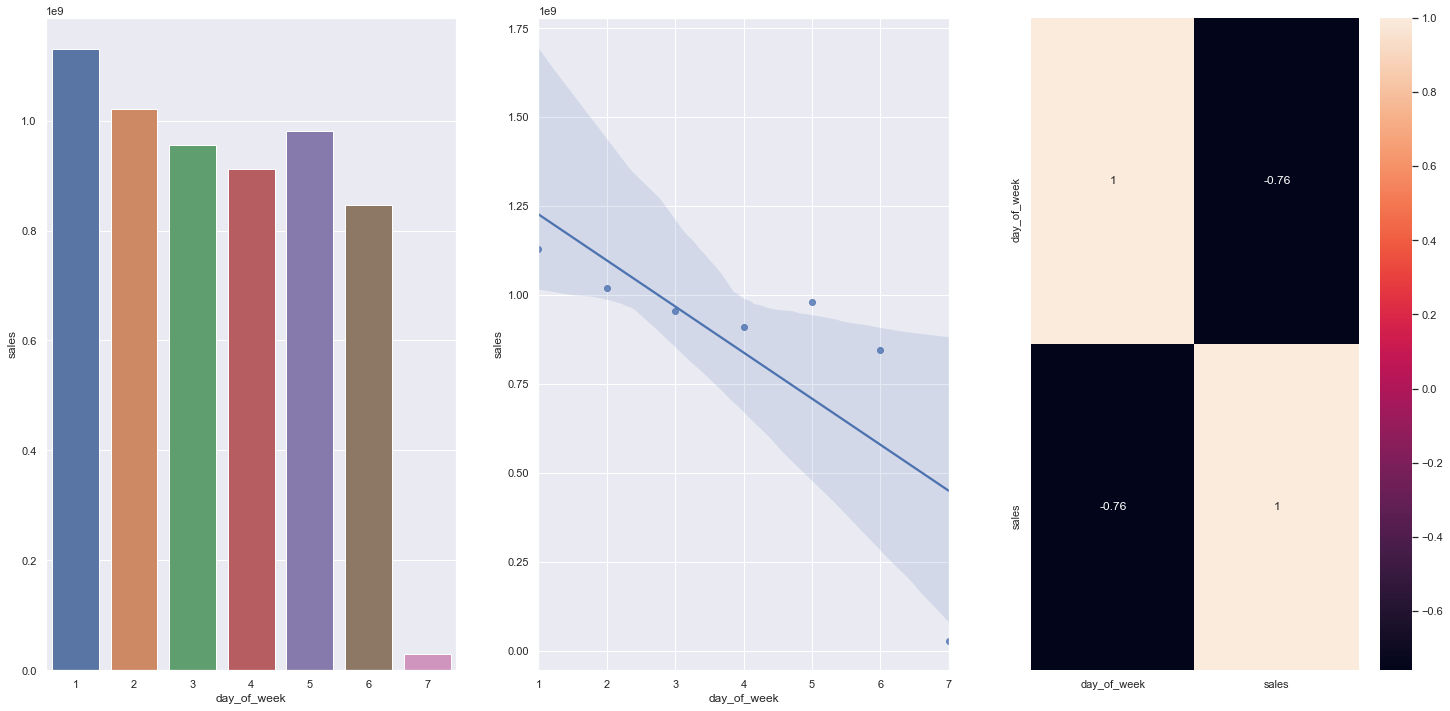

In [38]:
aux1 = df4[['day_of_week', 'sales']].groupby('day_of_week').sum().reset_index()

plt.subplot(1, 3, 1)
sns.barplot(x = 'day_of_week', y = 'sales', data = aux1)

plt.subplot(1, 3, 2)
sns.regplot(x = 'day_of_week', y = 'sales', data = aux1)

plt.subplot(1, 3, 3)
sns.heatmap(aux1.corr(method = 'pearson'), annot = True);

### H12. Stores should sell more during the school holidays.
**TRUE** - Stores sell more during the school holidays.

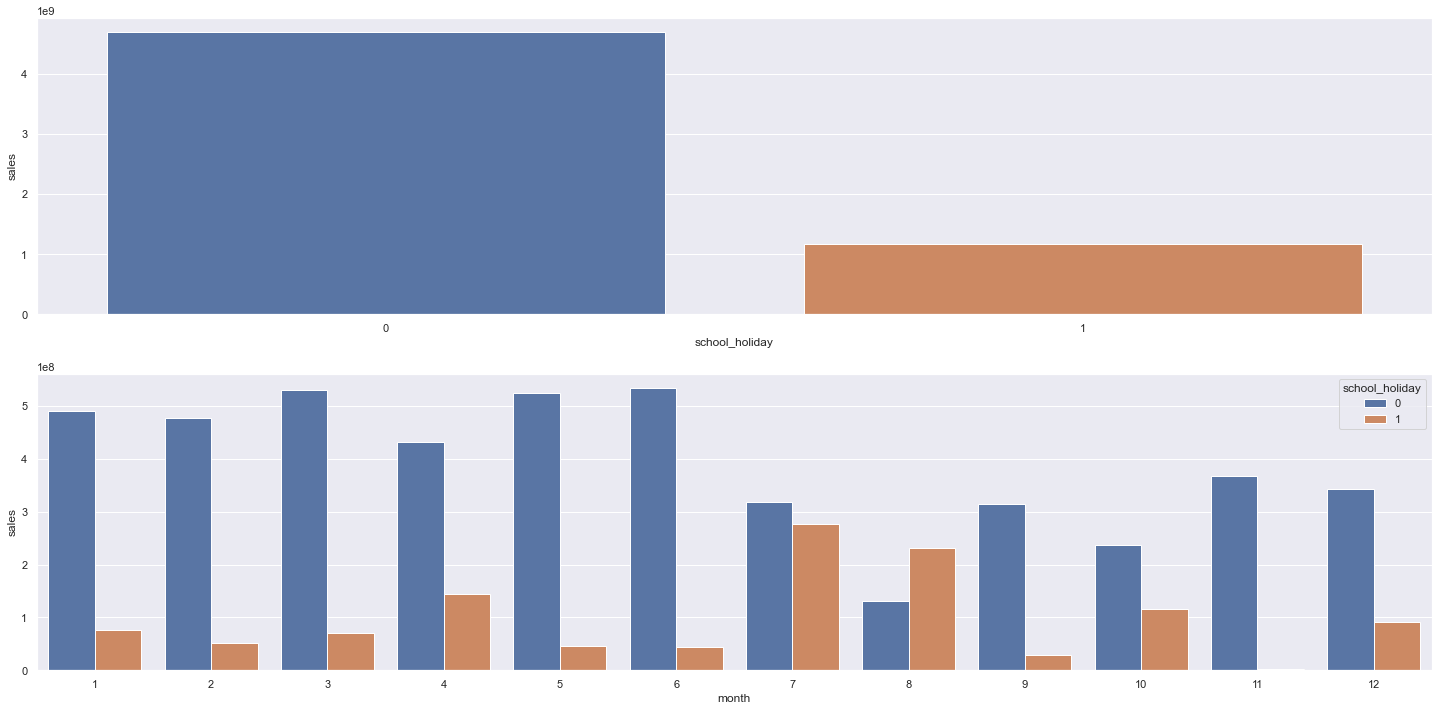

In [39]:
plt.subplot(2, 1, 1)
aux1 = df4[['school_holiday', 'sales']].groupby('school_holiday').sum().reset_index()
sns.barplot(x = 'school_holiday', y = 'sales', data = aux1);

plt.subplot(2, 1, 2)
aux2 = df4[['month', 'school_holiday', 'sales']].groupby(['month', 'school_holiday']).sum().reset_index()
sns.barplot(x = 'month', y = 'sales', hue = 'school_holiday', data = aux2);

### 4.2.1 Hypothesis' Summary

In [40]:
tab = [['Hypothesis', 'Conclusion', 'Relevance'],
       ['H1', 'FALSE', 'Low'],
       ['H2', 'FALSE', 'Medium'],
       ['H3', 'FALSE', 'Medium'],
       ['H4', 'FALSE', 'Low'],
       ['H5', '-', '-'],
       ['H6', 'FALSE', 'Low'],
       ['H7', 'FALSE', 'Medium'],
       ['H8', 'FALSE', 'High'],
       ['H9', 'FALSE', 'High'],
       ['H10', 'TRUE', 'High'],
       ['H11', 'TRUE', 'High'],
       ['H12', 'TRUE', 'Low'],
      ]

print(tabulate(tab, headers = 'firstrow'))

Hypothesis    Conclusion    Relevance
------------  ------------  -----------
H1            FALSE         Low
H2            FALSE         Medium
H3            FALSE         Medium
H4            FALSE         Low
H5            -             -
H6            FALSE         Low
H7            FALSE         Medium
H8            FALSE         High
H9            FALSE         High
H10           TRUE          High
H11           TRUE          High
H12           TRUE          Low


## 4.3 Multivariate Analysis

### 4.3.1 Numerical Attributes

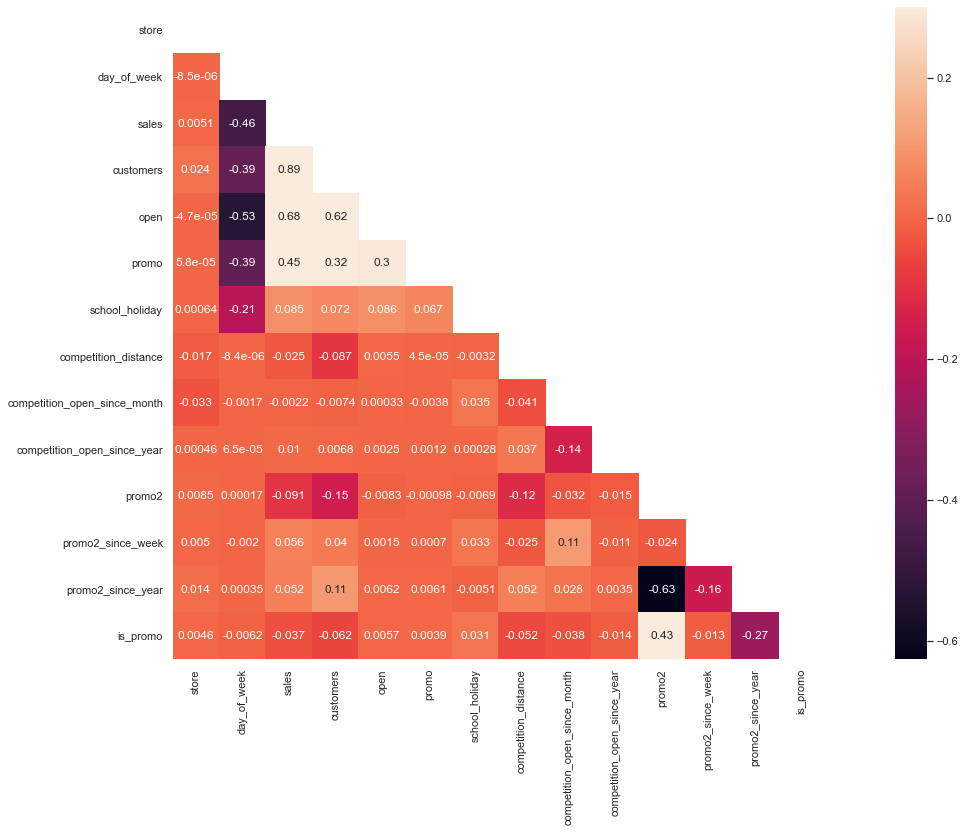

In [41]:
correlation = num_att.corr(method = 'pearson')
mask = np.zeros_like(correlation)
mask[np.triu_indices_from(mask)] = True
with sns.axes_style("white"):
    sns.heatmap(correlation, mask = mask, vmax = 0.3, square = True, annot = True);

### 4.3.2 Categorical Attributes

In [42]:
# only categorical attibutes

a = df4.select_dtypes(include = 'object')

# cramer v

a1 = cramer_v(a['state_holiday'], a['state_holiday'])
a2 = cramer_v(a['state_holiday'], a['store_type'])
a3 = cramer_v(a['state_holiday'], a['assortment'])

a4 = cramer_v(a['store_type'], a['state_holiday'])
a5 = cramer_v(a['store_type'], a['store_type'])
a6 = cramer_v(a['store_type'], a['assortment'])

a7 = cramer_v(a['assortment'], a['state_holiday'])
a8 = cramer_v(a['assortment'], a['store_type'])
a9 = cramer_v(a['assortment'], a['assortment'])

# dataset for correlation of categorical attibutes

d = pd.DataFrame({'state_holiday': [a1, a2, a3],
                  'store_type': [a4, a5, a6],
                  'assortment': [a7, a8, a9]
                 })

d = d.set_index(d.columns)

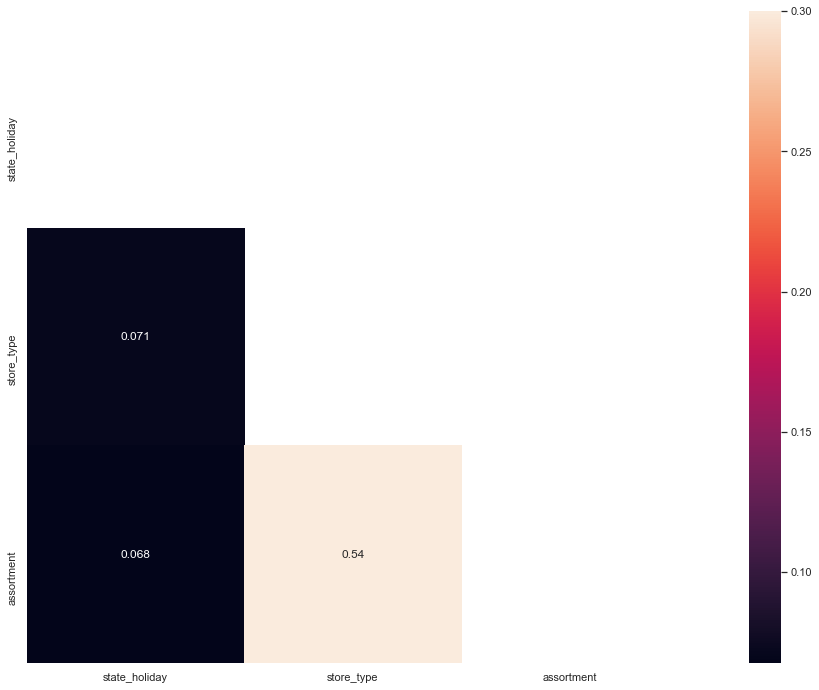

In [43]:
mask = np.zeros_like(d)
mask[np.triu_indices_from(mask)] = True
with sns.axes_style("white"):
    sns.heatmap(d, mask = mask, vmax = 0.3, square = True, annot = True);

# 5.0 DATA PREPARATION

In [45]:
df5 = df4.copy()

## 5.1 Normalization

Como não há variáveis que apresentam distribuição normal no dataset, a normalização não será aplicada em nenhuma das variáveis

## 5.2 Rescaling

In [46]:
rs = RobustScaler()
mms = MinMaxScaler()

# competition_distance

df5['competition_distance'] = rs.fit_transform(df5[['competition_distance']].values)
pickle.dump(rs, open('parameters/competition_distance_scaler.pkl', 'wb'))

# year

df5['year'] = mms.fit_transform(df5[['year']].values)
pickle.dump(mms, open('parameters/year_scaler.pkl', 'wb'))

# competition_time_month

df5['competition_time_month'] = rs.fit_transform(df5[['competition_time_month']].values)
pickle.dump(rs, open('parameters/competition_time_month_scaler.pkl', 'wb'))

# promo_time_week

df5['promo_time_week'] = mms.fit_transform(df5[['promo_time_week']].values)
pickle.dump(rs, open('parameters/promo_time_week_scaler.pkl', 'wb'))

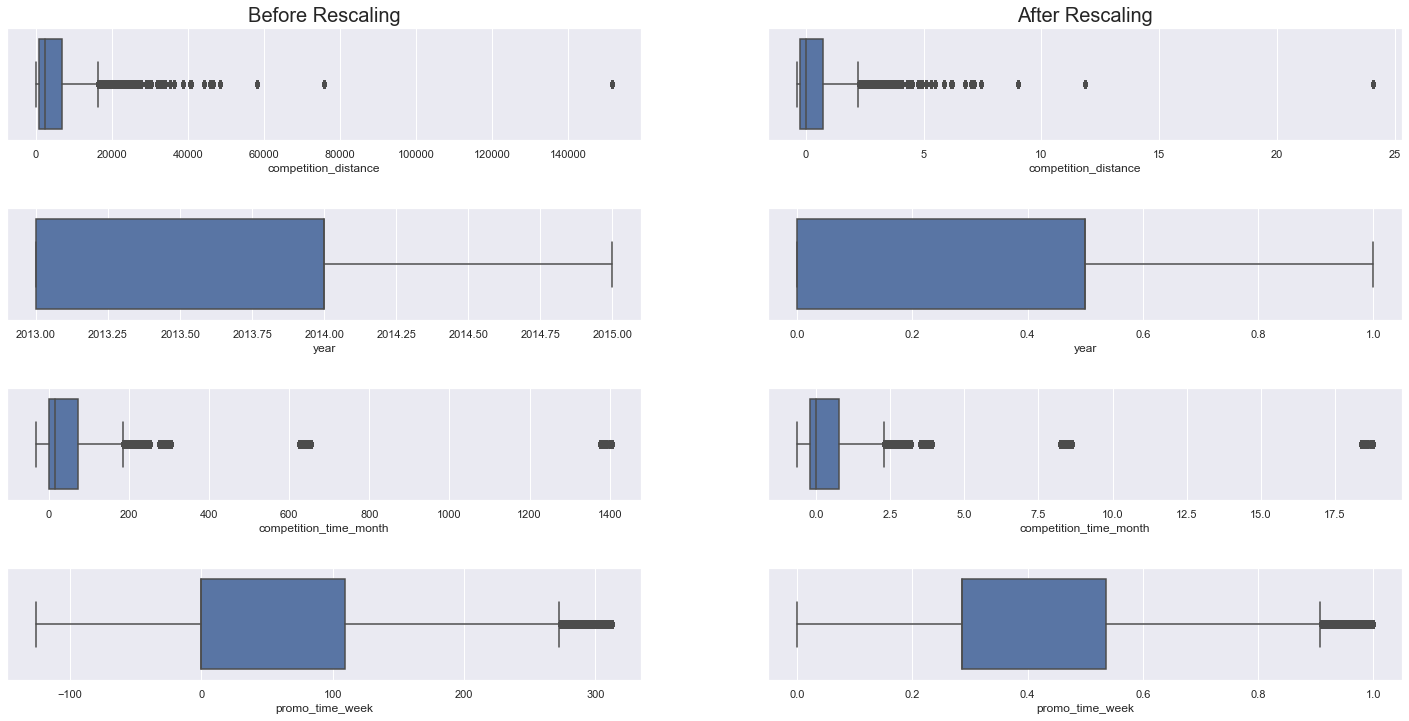

In [47]:
# competition_distance

plt.subplot(4,2,1)
sns.boxplot(x = 'competition_distance', data = df4)
plt.title('Before Rescaling', size = 20)
plt.subplot(4,2,2)
sns.boxplot(x = 'competition_distance', data = df5)
plt.title('After Rescaling', size = 20)


# year

plt.subplot(4,2,3)
sns.boxplot(x = 'year', data = df4)
plt.subplot(4,2,4)
sns.boxplot(x = 'year', data = df5)

# competition_time_month

plt.subplot(4,2,5)
sns.boxplot(x = 'competition_time_month', data = df4)
plt.subplot(4,2,6)
sns.boxplot(x = 'competition_time_month', data = df5)

# year

plt.subplot(4,2,7)
sns.boxplot(x = 'promo_time_week', data = df4)
plt.subplot(4,2,8)
sns.boxplot(x = 'promo_time_week', data = df5)

plt.subplots_adjust(hspace=0.6)

## 5.3 Transformation

### 5.3.1 Encoding

In [48]:
# state_holiday - one hot encoding

df5 = pd.get_dummies(df5, prefix = ['state_holiday'], columns = ['state_holiday'])

# store_type - label encoding

le = LabelEncoder()
df5['store_type'] = le.fit_transform(df5['store_type'])
pickle.dump(le, open('parameters/store_type_scaler.pkl', 'wb'))

# assortment - ordinal encoding

assortment_dict = {'basic': 1,
                   'extra': 2,
                   'extended': 3}

df5['assortment'] = df5['assortment'].map(assortment_dict)

In [49]:
# state_holiday
aux1_state_holiday = df4[['state_holiday']].head(5)
aux2_state_holiday = df5[['state_holiday_christmas', 'state_holiday_easter_holiday', 'state_holiday_public_holiday', 'state_holiday_regular_day']].head(5)
dfi.export(aux1_state_holiday, 'img/05.03.01_state_holiday_original.png')
dfi.export(aux2_state_holiday, 'img/05.03.01_state_holiday_encoded.png')

# store_type

aux1_store_type = df4[['store_type']].head(5)
aux2_store_type = df5[['store_type']].head(5)
dfi.export(aux1_store_type, 'img/05.03.01_store_type_original.png')
dfi.export(aux2_store_type, 'img/05.03.01_store_type_encoded.png')

# assortment

aux1_assortment = df4[['assortment']].head(5)
aux2_assortment = df5[['assortment']].head(5)
dfi.export(aux1_assortment, 'img/05.03.01_assortment_original.png')
dfi.export(aux2_assortment, 'img/05.03.01_assortment_encoded.png')

Before Encoding           |  After Encoding
:-------------------------:|:-------------------------:
![](img/05.03.01_state_holiday_original.png) | ![](img/05.03.01_state_holiday_encoded.png) 

Before Encoding           |  After Encoding
:-------------------------:|:-------------------------:
![](img/05.03.01_store_type_original.png) | ![](img/05.03.01_store_type_encoded.png) 

Before Encoding           |  After Encoding
:-------------------------:|:-------------------------:
![](img/05.03.01_assortment_original.png) | ![](img/05.03.01_assortment_encoded.png) 

### 5.3.2 Response Variable Transformation

In [51]:
df5['sales'] = np.log1p(df5['sales'])

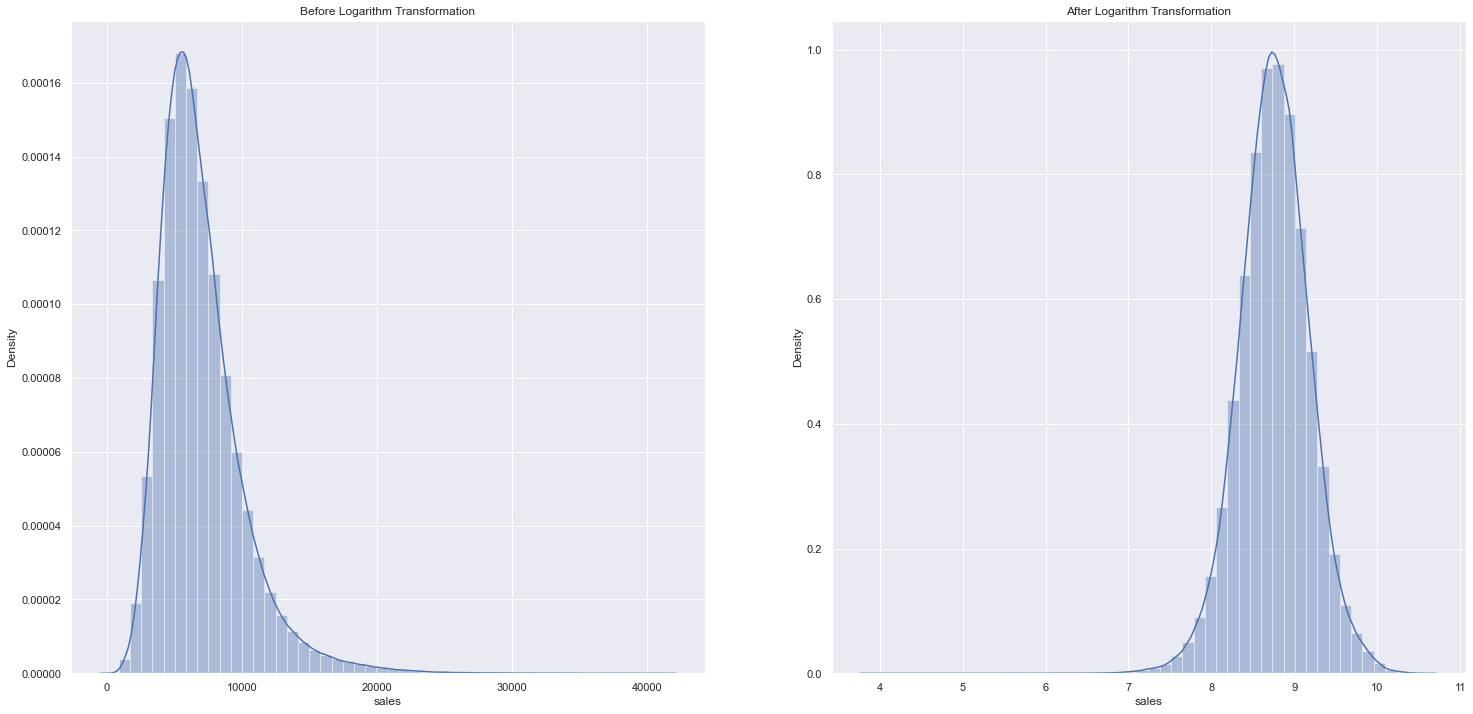

In [52]:
plt.subplot(1, 2, 1)
plt.title('Before Logarithm Transformation')
sns.distplot(df4['sales'])
plt.subplot(1, 2, 2)
plt.title('After Logarithm Transformation')
sns.distplot(df5['sales']);

### 5.3.3 Nature Transformation

In [53]:
# day_of_week

df5['day_of_week_sin'] = df5['day_of_week'].apply(lambda x: np.sin(x * (2 * np.pi / 7)))
df5['day_of_week_cos'] = df5['day_of_week'].apply(lambda x: np.cos(x * (2 * np.pi / 7)))

# month

df5['month_sin'] = df5['month'].apply(lambda x: np.sin(x * (2 * np.pi / 12)))
df5['month_cos'] = df5['month'].apply(lambda x: np.cos(x * (2 * np.pi / 12)))

# day

df5['day_sin'] = df5['day'].apply(lambda x: np.sin(x * (2 * np.pi / 30)))
df5['day_cos'] = df5['day'].apply(lambda x: np.cos(x * (2 * np.pi / 30)))

# week_of_year

df5['week_of_year_sin'] = df5['week_of_year'].apply(lambda x: np.sin(x * (2 * np.pi / 52)))
df5['week_of_year_cos'] = df5['week_of_year'].apply(lambda x: np.cos(x * (2 * np.pi / 52)))

In [54]:
head_tail_slice = list(range(5))+list(range(-5,0))

# cyclic variables original

aux1_nature_transformation = df4.iloc[head_tail_slice]
aux1_nature_transformation = aux1_nature_transformation[['day_of_week', 'month', 'day', 'week_of_year']]
dfi.export(aux1_nature_transformation, 'img/05.03.03_cyclic_variables_original.png')

# cyclic variables after nature transformation

aux2_nature_transformation = df5.iloc[head_tail_slice]
aux2_nature_transformation = aux2_nature_transformation[['day_of_week_sin', 'day_of_week_cos', 'month_sin', 'month_cos', 'day_sin', 'day_cos', 'week_of_year_sin', 'week_of_year_cos']]
dfi.export(aux2_nature_transformation, 'img/05.03.03_cyclic_variables_after.png')

Before Nature Transformation | After Nature Transformation
:-------------------------:|:-------------------------:
![](img/05.03.03_cyclic_variables_original.png) | ![](img/05.03.03_cyclic_variables_after.png) 

# 6.0 FEATURE SELECTION

In [56]:
df6 = df5.copy()

## 6.1 Split Dataframe into Training and Test

In [57]:
# deleting cols used to create features

cols_drop = ['week_of_year', 'day', 'month', 'day_of_week', 'promo_since', 'competition_since', 'year_week']

df6 = df6.drop(cols_drop, axis = 1)

In [58]:
# selecting 6 weeks before the max date for test
test_period = df6[['store', 'date']].groupby('store').max().reset_index()['date'][0] - datetime.timedelta(days = 7 * 6)
test_period

Timestamp('2015-06-19 00:00:00')

In [59]:
# training dataset

X_train = df6[df6['date'] < test_period]
y_train = X_train['sales']

# test dataset
X_test = df6[df6['date'] >= test_period]
y_test = X_test['sales']

print('Training Min Date: {}'.format(X_train['date'].min()))
print('Training Min Date: {}'.format(X_train['date'].max()))
print('-----')
print('Test Min Date: {}'.format(X_test['date'].min()))
print('Test Min Date: {}'.format(X_test['date'].max()))

Training Min Date: 2013-01-01 00:00:00
Training Min Date: 2015-06-18 00:00:00
-----
Test Min Date: 2015-06-19 00:00:00
Test Min Date: 2015-07-31 00:00:00


## 6.2 Feature Selection with Boruta

In [60]:
# training and test dataset for boruta

X_train_n = X_train.drop(['date', 'sales'], axis = 1).values

y_train_n = y_train.values.ravel()

# define random forest regressor

rf = RandomForestRegressor(n_jobs = -1)

# define boruta

boruta = BorutaPy(rf, n_estimators = 'auto', verbose = 2, random_state = 42).fit(X_train_n, y_train_n)

Iteration: 	1 / 100
Confirmed: 	0
Tentative: 	27
Rejected: 	0
Iteration: 	2 / 100
Confirmed: 	0
Tentative: 	27
Rejected: 	0
Iteration: 	3 / 100
Confirmed: 	0
Tentative: 	27
Rejected: 	0
Iteration: 	4 / 100
Confirmed: 	0
Tentative: 	27
Rejected: 	0
Iteration: 	5 / 100
Confirmed: 	0
Tentative: 	27
Rejected: 	0
Iteration: 	6 / 100
Confirmed: 	0
Tentative: 	27
Rejected: 	0
Iteration: 	7 / 100
Confirmed: 	0
Tentative: 	27
Rejected: 	0
Iteration: 	8 / 100
Confirmed: 	18
Tentative: 	0
Rejected: 	9


BorutaPy finished running.

Iteration: 	9 / 100
Confirmed: 	18
Tentative: 	0
Rejected: 	9


### 6.2.1 Best Features from Boruta

In [61]:
cols_selected = boruta.support_.tolist()

# best features

X_train_fs = X_train.drop(['date', 'sales'], axis = 1)
cols_selected_boruta = X_train_fs.iloc[:, cols_selected].columns.to_list()

# no selected

cols_not_selected_boruta = list(np.setdiff1d(X_train_fs.columns, cols_selected_boruta))

In [62]:
cols_selected_boruta

['store',
 'promo',
 'store_type',
 'assortment',
 'competition_distance',
 'competition_open_since_month',
 'competition_open_since_year',
 'promo2',
 'promo2_since_week',
 'promo2_since_year',
 'competition_time_month',
 'promo_time_week',
 'day_of_week_sin',
 'day_of_week_cos',
 'month_cos',
 'day_sin',
 'day_cos',
 'week_of_year_cos']

## 6.3 Manual Feature Selection

In [63]:
cols_selected_boruta = ['store',
                        'promo',
                        'store_type',
                        'assortment',
                        'competition_distance',
                        'competition_open_since_month',
                        'competition_open_since_year',
                        'promo2',
                        'promo2_since_week',
                        'promo2_since_year',
                        'competition_time_month',
                        'promo_time_week',
                        'month_cos',
                        'month_sin',
                        'day_of_week_sin',
                        'day_of_week_cos',
                        'day_sin',
                        'day_cos',
                        'week_of_year_cos',
                        'week_of_year_sin']

cols_not_selected_boruta = ['is_promo',
                            'school_holiday',
                            'state_holiday_christmas',
                            'state_holiday_easter_holiday',
                            'state_holiday_public_holiday',
                            'state_holiday_regular_day',
                            'year']

# columns to add

features_to_add = ['date', 'sales']

# final list of features
cols_selected_boruta_full = cols_selected_boruta.copy()
cols_selected_boruta_full.extend(features_to_add)

# 7.0 MACHINE LEARNING MODELLING

In [64]:
df7 = df6.copy()

In [65]:
# train, test dataset

x_train = X_train[cols_selected_boruta]
x_test = X_test[cols_selected_boruta]

# time series cross validation 

x_training = X_train[cols_selected_boruta_full]

## 7.1 Average Model

In [66]:
aux1 = x_test.copy()
aux1['sales'] = y_test.copy()

# prediction

aux2 = aux1[['store', 'sales']].groupby('store').mean().reset_index().rename(columns = {'sales': 'predictions'})
aux1 = pd.merge(aux1, aux2, how = 'left', on = 'store')
y_hat_baseline = aux1['predictions']

# performance

baseline_result = ml_error('Avarage Model', np.expm1(y_test), np.expm1(y_hat_baseline))
baseline_result

,MAE,MAPE,RMSE
Avarage Model,1354.800353,0.455051,1835.135542


## 7.2 Linear Regression Model

In [67]:
# model

lr = LinearRegression().fit(x_train, y_train)

# prediction

y_hat_lr = lr.predict(x_test)

# performance

lr_result = ml_error('Linear Regression', np.expm1(y_test), np.expm1(y_hat_lr))
lr_result

,MAE,MAPE,RMSE
Linear Regression,1868.367109,0.292879,2670.993696


### 7.2.1 Linear Regression Model - Cross Validation

In [68]:
lr_result_cv = cross_validation('Linear Regression', lr, x_training, 5, verbose = True)
lr_result_cv


KFold Number: 5

KFold Number: 4

KFold Number: 3

KFold Number: 2

KFold Number: 1


,MAE CV,MAPE CV,RMSE CV
Linear Regression,2081.9 +/- 295.72,0.3 +/- 0.02,2951.31 +/- 468.65


## 7.3 Linear Regression Regularized Model - Lasso

In [69]:
# model

lasso = Lasso(alpha = 0.01).fit(x_train, y_train)

# prediction

y_hat_lasso = lasso.predict(x_test)

# performance

lasso_result = ml_error('Lasso Regression', np.expm1(y_test), np.expm1(y_hat_lasso))
lasso_result

,MAE,MAPE,RMSE
Lasso Regression,1892.318507,0.289171,2744.364675


### 7.3.1 Linear Regression Regularized Model - Lasso - Cross Validation

In [70]:
lasso_result_cv = cross_validation('Lasso', lasso, x_training, 5, verbose = True)
lasso_result_cv


KFold Number: 5

KFold Number: 4

KFold Number: 3

KFold Number: 2

KFold Number: 1


,MAE CV,MAPE CV,RMSE CV
Lasso,2116.39 +/- 341.57,0.29 +/- 0.01,3057.09 +/- 504.39


## 7.4 Random Forest Regressor

In [71]:
# model

rf = RandomForestRegressor(n_estimators = 100, n_jobs = -1, random_state = 42).fit(x_train, y_train)

# prediction

y_hat_rf = rf.predict(x_test)

# performance

rf_result = ml_error('Random Forest', np.expm1(y_test), np.expm1(y_hat_rf))
rf_result

,MAE,MAPE,RMSE
Random Forest,680.091348,0.099966,1011.733636


### 7.4.1 Random Forest Regressor - Cross Validation

In [72]:
rf_result_cv = cross_validation('Random Forest', rf, x_training, 5, verbose = True)
rf_result_cv


KFold Number: 5

KFold Number: 4

KFold Number: 3

KFold Number: 2

KFold Number: 1


,MAE CV,MAPE CV,RMSE CV
Random Forest,837.65 +/- 218.72,0.12 +/- 0.02,1256.27 +/- 319.16


## 7.5 XGBoost Regressor

In [73]:
# model

model_xgb = xgb.XGBRegressor(objective = 'reg:squarederror',
                             n_estimators = 100,
                             eta = 0.01,
                             max_depth = 10,
                             subsample = 0.7,
                             colsample_bytree = 0.9).fit(x_train, y_train)

# prediction

y_hat_xgb = model_xgb.predict(x_test)

# performance

xgb_result = ml_error('XGBoost', np.expm1(y_test), np.expm1(y_hat_xgb))
xgb_result

,MAE,MAPE,RMSE
XGBoost,6683.52663,0.949461,7330.774457


### 7.5.1 XGBoost Regressor - Cross Validation

In [74]:
xgb_result_cv = cross_validation('XGBoost', model_xgb, x_training, 5, verbose = True)
xgb_result_cv


KFold Number: 5

KFold Number: 4

KFold Number: 3

KFold Number: 2

KFold Number: 1


,MAE CV,MAPE CV,RMSE CV
XGBoost,7049.09 +/- 588.53,0.95 +/- 0.0,7715.12 +/- 689.43


## 7.6 Compare Model's Performance

### 7.6.1 Single Performance

In [75]:
models_results = pd.concat([baseline_result, lr_result, lasso_result, rf_result, xgb_result])
models_results.sort_values('RMSE')

,MAE,MAPE,RMSE
Random Forest,680.091348,0.099966,1011.733636
Avarage Model,1354.800353,0.455051,1835.135542
Linear Regression,1868.367109,0.292879,2670.993696
Lasso Regression,1892.318507,0.289171,2744.364675
XGBoost,6683.526630,0.949461,7330.774457


In [77]:
dfi.export(models_results.sort_values('RMSE'), 'img/07.01_models_single_performance.png')

### 7.6.2 Real Performance - Cross Validation

In [76]:
models_results_cv = pd.concat([lr_result_cv, lasso_result_cv, rf_result_cv, xgb_result_cv])
models_results_cv.sort_values('RMSE CV')

,MAE CV,MAPE CV,RMSE CV
Random Forest,837.65 +/- 218.72,0.12 +/- 0.02,1256.27 +/- 319.16
Linear Regression,2081.9 +/- 295.72,0.3 +/- 0.02,2951.31 +/- 468.65
Lasso,2116.39 +/- 341.57,0.29 +/- 0.01,3057.09 +/- 504.39
XGBoost,7049.09 +/- 588.53,0.95 +/- 0.0,7715.12 +/- 689.43


In [78]:
dfi.export(models_results_cv.sort_values('RMSE CV'), 'img/07.03_models_crossvalidation_performance.png')

# 8.0 HYPERPARAMETER FINE TUNING

## 8.1 Random Search

In [79]:
import random

# parameters dictionary

parameters = {'n_estimators': [1500, 1700, 2500, 3000, 3500],
              'eta': [0.01, 0.03],
              'max_depth': [3, 5, 9],
              'subsample': [0.1, 0.5, 0.7],
              'colsample_bytree': [0.3, 0.7, 0.9],
              'min_child_weight': [3, 8, 15]
             }

MAX_EVAL = 10

final_result = pd.DataFrame()

# loop for random search

for i in range(MAX_EVAL):
    
    # choose values for parameters randomly
    
    hp = {k: random.sample(v, 1)[0] for k, v in parameters.items()}
    print(hp)

    # model
    
    model_xgb = xgb.XGBRegressor(objective = 'reg:squarederror',
                                 n_estimators = hp['n_estimators'],
                                 eta = hp['eta'],
                                 max_depth = hp['max_depth'],
                                 subsample = hp['subsample'],
                                 colsample_bytree = hp['colsample_bytree'], 
                                 min_child_weight = hp['min_child_weight'])
       
    # performance
    
    result = cross_validation('XGBoost', model_xgb, x_training, 2, verbose = False)
    final_result = pd.concat([final_result, result])
    
final_result

{'n_estimators': 2500, 'eta': 0.03, 'max_depth': 5, 'subsample': 0.7, 'colsample_bytree': 0.7, 'min_child_weight': 15}
{'n_estimators': 1700, 'eta': 0.03, 'max_depth': 3, 'subsample': 0.7, 'colsample_bytree': 0.9, 'min_child_weight': 8}
{'n_estimators': 3500, 'eta': 0.03, 'max_depth': 9, 'subsample': 0.7, 'colsample_bytree': 0.3, 'min_child_weight': 3}
{'n_estimators': 1500, 'eta': 0.03, 'max_depth': 9, 'subsample': 0.7, 'colsample_bytree': 0.3, 'min_child_weight': 8}
{'n_estimators': 1500, 'eta': 0.03, 'max_depth': 5, 'subsample': 0.1, 'colsample_bytree': 0.9, 'min_child_weight': 15}
{'n_estimators': 3500, 'eta': 0.01, 'max_depth': 9, 'subsample': 0.7, 'colsample_bytree': 0.7, 'min_child_weight': 15}
{'n_estimators': 3000, 'eta': 0.03, 'max_depth': 3, 'subsample': 0.5, 'colsample_bytree': 0.3, 'min_child_weight': 3}
{'n_estimators': 2500, 'eta': 0.01, 'max_depth': 9, 'subsample': 0.7, 'colsample_bytree': 0.3, 'min_child_weight': 8}
{'n_estimators': 3500, 'eta': 0.03, 'max_depth': 9, '

,MAE CV,MAPE CV,RMSE CV
XGBoost,948.0 +/- 72.24,0.13 +/- 0.0,1371.55 +/- 136.66
XGBoost,1473.74 +/- 47.53,0.2 +/- 0.0,2157.71 +/- 92.45
XGBoost,841.7 +/- 86.21,0.11 +/- 0.01,1217.95 +/- 169.77
XGBoost,878.82 +/- 82.75,0.12 +/- 0.01,1270.15 +/- 162.15
XGBoost,1051.57 +/- 62.45,0.14 +/- 0.0,1525.98 +/- 115.94
XGBoost,840.29 +/- 84.33,0.11 +/- 0.01,1225.09 +/- 155.83
XGBoost,1395.23 +/- 56.02,0.19 +/- 0.0,2036.34 +/- 99.0
XGBoost,956.72 +/- 80.26,0.13 +/- 0.01,1386.62 +/- 148.42
XGBoost,805.06 +/- 89.95,0.11 +/- 0.01,1172.89 +/- 164.04
XGBoost,840.5 +/- 81.82,0.11 +/- 0.01,1220.72 +/- 145.87


## 8.2 Final Model

In [80]:
# parameters dictionary

# 9 - {'n_estimators': 3500, 'eta': 0.03, 'max_depth': 9, 'subsample': 0.7, 'colsample_bytree': 0.9, 'min_child_weight': 15}

parameters_tuned = {'n_estimators': 1500,
                    'eta': 0.03,
                    'max_depth': 9,
                    'subsample': 0.7,
                    'colsample_bytree': 0.7,
                    'min_child_weight': 15 
                    }

# model

model_xgb_tuned = xgb.XGBRegressor(objective = 'reg:squarederror',
                                   n_estimators = parameters_tuned['n_estimators'],
                                   eta = parameters_tuned['eta'],
                                   max_depth = parameters_tuned['max_depth'],
                                   subsample = parameters_tuned['subsample'],
                                   colsample_bytree = parameters_tuned['colsample_bytree'], 
                                   min_child_weight = parameters_tuned['min_child_weight']).fit(x_train, y_train)

# saving the final model

pickle.dump(model_xgb_tuned, open('model/rossmann_prediction_model.pkl', 'wb'))

In [81]:
# loading the model

model = pickle.load(open('model/rossmann_prediction_model.pkl', 'rb'))

# prediction

yhat_xgb_tuned = model.predict(x_test)
   
# performance

xgb_result_tuned = ml_error('XGBoost', np.expm1(y_test), np.expm1(yhat_xgb_tuned))
xgb_result_tuned

,MAE,MAPE,RMSE
XGBoost,644.436763,0.094262,942.933173


# 9.0 UNDERSTANDING MODEL'S ERROR

In [82]:
df9 = X_test[cols_selected_boruta_full]

# rescale

df9['sales'] = np.expm1(df9['sales'])
df9['predictions'] = np.expm1(yhat_xgb_tuned)
df9.head()

,store,promo,store_type,assortment,competition_distance,competition_open_since_month,competition_open_since_year,promo2,promo2_since_week,promo2_since_year,competition_time_month,promo_time_week,month_cos,month_sin,day_of_week_sin,day_of_week_cos,day_sin,day_cos,week_of_year_cos,week_of_year_sin,date,sales,predictions
0,1,1,2,1,-0.170968,9,2008,0,31,2015,0.918919,0.287016,-0.866025,-0.5,-0.974928,-0.222521,0.207912,0.978148,-0.822984,-0.568065,2015-07-31,5263.0,5682.219727
1,2,1,0,1,-0.283871,11,2007,1,13,2010,1.054054,0.922551,-0.866025,-0.5,-0.974928,-0.222521,0.207912,0.978148,-0.822984,-0.568065,2015-07-31,6064.0,6031.892090
2,3,1,0,1,1.903226,12,2006,1,14,2011,1.202703,0.801822,-0.866025,-0.5,-0.974928,-0.222521,0.207912,0.978148,-0.822984,-0.568065,2015-07-31,8314.0,9358.828125
3,4,1,2,3,-0.275806,9,2009,0,31,2015,0.743243,0.287016,-0.866025,-0.5,-0.974928,-0.222521,0.207912,0.978148,-0.822984,-0.568065,2015-07-31,13995.0,12405.416992
4,5,1,0,1,4.448387,4,2015,0,31,2015,-0.162162,0.287016,-0.866025,-0.5,-0.974928,-0.222521,0.207912,0.978148,-0.822984,-0.568065,2015-07-31,4822.0,6550.284668


## 9.1 Business Performance

In [84]:
# sum of predictions

df9_aux1 = df9[['store', 'predictions']].groupby('store').sum().reset_index()

# MAE and MAPE

df9_aux2 = df9[['store', 'sales', 'predictions']].groupby('store').apply(lambda x: mean_absolute_error(x['sales'], x['predictions'])).reset_index().rename(columns = {0: 'MAE'})
df9_aux3 = df9[['store', 'sales', 'predictions']].groupby('store').apply(lambda x: mean_absolute_percentage_error(x['sales'], x['predictions'])).reset_index().rename(columns = {0: 'MAPE'})

# merge

df9_aux4 = pd.merge(df9_aux2, df9_aux3, how = 'inner', on = 'store')
df9_aux5 = pd.merge(df9_aux1, df9_aux4, how = 'inner', on = 'store')
df9_aux5

# scenarios

df9_aux5['worst_scenario'] = df9_aux5['predictions'] - (df9_aux5['predictions'] * df9_aux5['MAPE'] )
df9_aux5['best_scenario'] = df9_aux5['predictions'] + (df9_aux5['predictions'] * df9_aux5['MAPE'] )

# ordering columns

df9_aux5 = df9_aux5[['store', 'predictions', 'worst_scenario', 'best_scenario', 'MAE', 'MAPE']]

In [85]:
df9_aux5.sample(4)

,store,predictions,worst_scenario,best_scenario,MAE,MAPE
1084,1085,252907.515625,234182.381554,271632.649696,495.658599,0.074039
829,830,225242.218750,206077.879628,244406.557872,556.132832,0.085083
523,524,320214.562500,297689.275415,342739.849585,514.052439,0.070344
767,768,459372.750000,425851.559280,492893.940720,1066.124683,0.072972


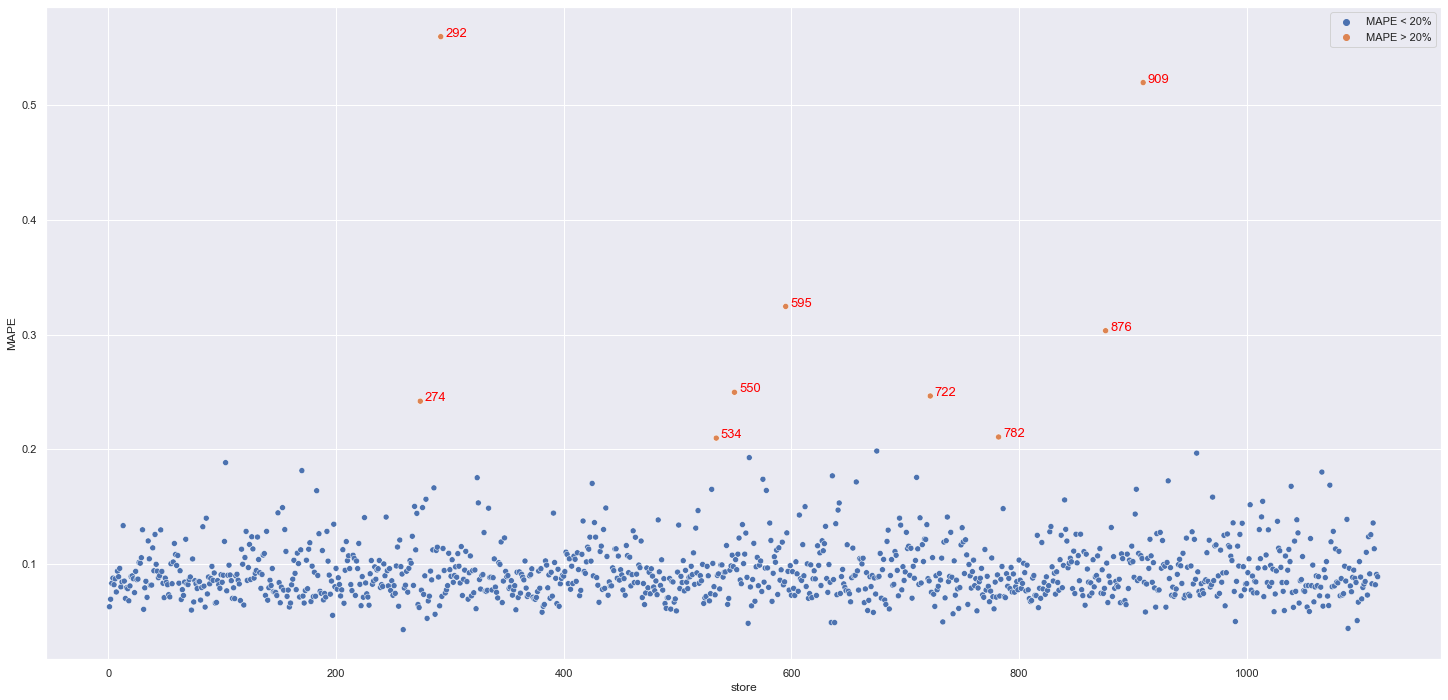

In [86]:
# stores with MAPE > than 20%

df9_aux6 = df9_aux5[df9_aux5.MAPE > 0.2]
hue = ['MAPE > 20%' if y > 0.20 else 'MAPE < 20%' for y in df9_aux5.MAPE]

sns.scatterplot(x = 'store', y = 'MAPE', hue = hue, data = df9_aux5)
for i in range(df9_aux5.shape[0]):
    if i in df9_aux6.store:
        plt.text(x=df9_aux5['store'][i] + 4,y=df9_aux5['MAPE'][i],s=df9_aux5['store'][i], 
              fontdict=dict(color='red',size=13))

In [87]:
df9_aux6.sort_values('MAPE', ascending = False)

,store,predictions,worst_scenario,best_scenario,MAE,MAPE
291,292,105408.781250,46402.006072,164415.556428,3334.984915,0.559790
908,909,236676.328125,113668.323235,359684.333015,7644.379479,0.519731
594,595,355340.656250,240029.447610,470651.864890,4699.252521,0.324509
875,876,203028.562500,141440.721808,264616.403192,3942.968294,0.303346
549,550,240774.359375,180663.858744,300884.860006,1308.685362,0.249655
721,722,347536.750000,261903.744792,433169.755208,1844.344397,0.246400
273,274,193053.546875,146357.475306,239749.618444,1402.754616,0.241881
781,782,214500.562500,169314.039388,259687.085612,717.288007,0.210659
533,534,278672.125000,220236.404884,337107.845116,1372.650853,0.209693


## 9.2 Total Performance

In [88]:
# summary

df_total_performance = df9_aux5[['predictions', 'worst_scenario', 'best_scenario']].apply(lambda x: np.sum(x), axis = 0).reset_index().rename(columns = {'index': 'Scenario', 0: 'Values'})
df_total_performance['Values'] = df_total_performance['Values'].map('€{:,.2f}'.format)
df_total_performance

,Scenario,Values
0,predictions,"€285,068,160.00"
1,worst_scenario,"€258,561,074.66"
2,best_scenario,"€311,575,244.74"


## 9.3 Machine Learning Performance

In [89]:
df9['error'] = df9['sales'] - df9['predictions']
df9['error_rate'] = df9['predictions'] / df9['sales']

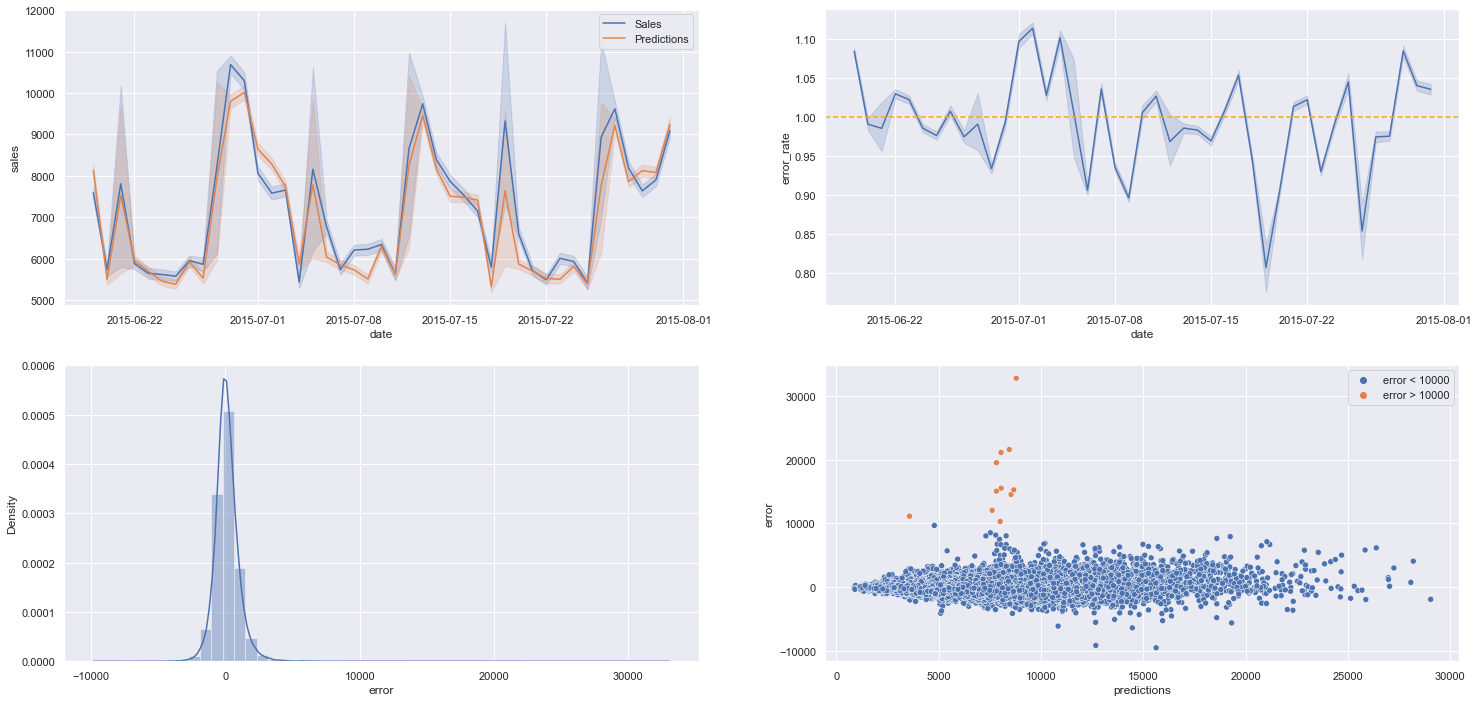

In [90]:
plt.subplot(2, 2, 1)
sns.lineplot(x = 'date', y = 'sales', data = df9, label = 'Sales')
sns.lineplot(x = 'date', y = 'predictions', data = df9, label = 'Predictions')

plt.subplot(2, 2, 2)
sns.lineplot(x = 'date', y = 'error_rate', data = df9)
plt.axhline(1, linestyle = '--', color = 'orange')

plt.subplot(2, 2, 3)
sns.distplot(df9['error'])

plt.subplot(2, 2, 4)
hue = ['error > 10000' if y > 10000 else 'error < 10000' for y in df9['error']]
sns.scatterplot(x = 'predictions', y = 'error', hue = hue, data = df9);

# 10.0 MODEL DEPLOYMENT

## 10.1 Rossmann Class

In [144]:
import pickle
import inflection
import pandas as pd
import numpy as np
import math
import datetime


class Rossmann(object):
    def __init__(self):
        self.home_path = '/home/gabriel/Documentos/repos/projects/rossmann_prediction/'
        self.competition_distance_scaler   = pickle.load(open(self.home_path + 'parameters/competition_distance_scaler.pkl', 'rb'))
        self.competition_time_month_scaler = pickle.load(open(self.home_path + 'parameters/competition_time_month_scaler.pkl', 'rb'))
        self.promo_time_week_scaler        = pickle.load(open(self.home_path + 'parameters/promo_time_week_scaler.pkl', 'rb'))
        self.year_scaler                   = pickle.load(open(self.home_path + 'parameters/year_scaler.pkl', 'rb'))
        self.store_type_scaler             = pickle.load(open(self.home_path + 'parameters/store_type_scaler.pkl', 'rb'))
        
    def data_cleaning(self, df1):
    
        # original name of the columns

        cols_old = ['Store', 'DayOfWeek', 'Date', 'Open', 'Promo',
                    'StateHoliday', 'SchoolHoliday', 'StoreType', 'Assortment',
                    'CompetitionDistance', 'CompetitionOpenSinceMonth',
                    'CompetitionOpenSinceYear', 'Promo2', 'Promo2SinceWeek',
                    'Promo2SinceYear', 'PromoInterval']
        
        # using inflection to create the new cols
        
        snake_case = lambda x: inflection.underscore(x)
        
        cols_new = list(map(snake_case, cols_old))

        # renaming the cols

        df1.columns = cols_new

        # transforming date to datetime
        
        df1['date'] = pd.to_datetime(df1['date'])

        # competition_distance
        
        max_value = df1['competition_distance'].max()
        
        df1['competition_distance'] = df1['competition_distance'].apply(lambda x: max_value * 2 if math.isnan(x) else x)
        
        # competition_open_since_month
        
        df1['competition_open_since_month'] = df1.apply(lambda x: x['date'].month if math.isnan(x['competition_open_since_month']) else x['competition_open_since_month'], axis = 1)
        
        # competition_open_since_year 
        
        df1['competition_open_since_year'] = df1.apply(lambda x: x['date'].year if math.isnan(x['competition_open_since_year']) else x['competition_open_since_year'], axis = 1)
        
        # promo2_since_week  
        
        df1['promo2_since_week'] = df1.apply(lambda x: x['date'].week if math.isnan(x['promo2_since_week']) else x['promo2_since_week'], axis = 1)
        
        # promo2_since_year
        
        df1['promo2_since_year'] = df1.apply(lambda x: x['date'].year if math.isnan(x['promo2_since_year']) else x['promo2_since_year'], axis = 1)
        
        # promo_interval           
        
        month_map = {1:'Jan',
                     2:'Feb',
                     3:'Mar',
                     4:'Apr',
                     5:'Mai',
                     6:'Jun',
                     7:'Jul',
                     8:'Aug',
                     9:'Sep',
                     10:'Oct',
                     11:'Nov',
                     12:'Dec'}
        
        df1['promo_interval'].fillna(0, inplace = True)
        
        df1['month_map'] = df1['date'].dt.month.map(month_map)
        
        df1['is_promo'] = df1[['promo_interval', 'month_map']].apply(lambda x: 0 if x['promo_interval'] == 0 else 1 if x['month_map'] in x['promo_interval'].split(',') else 0, axis = 1)

        # changing the variable type from float to int
        
        df1['competition_open_since_month'] = df1['competition_open_since_month'].astype(int)
        
        df1['competition_open_since_year'] = df1['competition_open_since_year'].astype(int)
        
        df1['promo2_since_week'] = df1['promo2_since_week'].astype(int)
        
        df1['promo2_since_year'] = df1['promo2_since_year'].astype(int)
        
        return df1
    
    def feature_engineering(self, df2):

        # year

        df2['year'] = df2['date'].dt.year

        # month

        df2['month'] = df2['date'].dt.month

        # day

        df2['day'] = df2['date'].dt.day

        # week_of_year

        df2['week_of_year'] = df2['date'].dt.weekofyear

        # year_week

        df2['year_week'] = df2['date'].dt.strftime('%Y-%W')

        # competition_since

        df2['competition_since'] = df2.apply(lambda x: datetime.datetime(year = x['competition_open_since_year'], month = x['competition_open_since_month'], day = 1), axis = 1)
        df2['competition_time_month'] = ((df2['date'] - df2['competition_since']) / 30).apply(lambda x: x.days).astype(int)

        # promo_since

        df2['promo_since'] = df2['promo2_since_year'].astype(str) + '-' + df2['promo2_since_week'].astype(str)
        df2['promo_since'] = df2['promo_since'].apply(lambda x: datetime.datetime.strptime(x + '-1', '%Y-%W-%w') - datetime.timedelta(days = 7))
        df2['promo_time_week'] = ((df2['date'] - df2['promo_since']) / 7).apply(lambda x: x.days).astype(int)

        # assortment

        df2['assortment'] = df2['assortment'].apply(lambda x: 'basic' if x == 'a' else 'extra' if x == 'b' else 'extended')

        # state_holiday

        df2['state_holiday'] = df2['state_holiday'].apply(lambda x: 'public_holiday' if x == 'a' else 'easter_holiday' if x == 'b' else 'christmas' if x == 'c' else 'regular_day')

        df2.head().T

        # 3.0 FEATURE FILTERING

        ## 3.1 Rows Filtering

        df2 = df2[df2['open'] != 0]

        ## 3.1 Cols Selection

        cols_drop = ['open', 'promo_interval', 'month_map']
        df2 = df2.drop(cols_drop, axis = 1)
        
        return df2
    
    def data_preparation(self, df5):

        ## 5.2 Rescaling

        # competition_distance

        df5['competition_distance'] = self.competition_distance_scaler.fit_transform(df5[['competition_distance']].values)
        
        # year

        df5['year'] = self.year_scaler.fit_transform(df5[['year']].values)

        # competition_time_month

        df5['competition_time_month'] = self.competition_time_month_scaler.fit_transform(df5[['competition_time_month']].values)

        # promo_time_week

        df5['promo_time_week'] = self.promo_time_week_scaler.fit_transform(df5[['promo_time_week']].values)


        ## 5.3 Transformation

        ### 5.3.1 Encoding

        # state_holiday - one hot encoding

        df5 = pd.get_dummies(df5, prefix = ['state_holiday'], columns = ['state_holiday'])

        # store_type - label encoding

        df5['store_type'] = self.store_type_scaler.fit_transform(df5['store_type'])

        # assortment - ordinal encoding

        assortment_dict = {'basic': 1,
                           'extra': 2,
                           'extended': 3}

        df5['assortment'] = df5['assortment'].map(assortment_dict)

        ### 5.3.3 Nature Transformation
        
        # day_of_week
        
        df5['day_of_week_sin'] = df5['day_of_week'].apply(lambda x: np.sin(x * (2 * np.pi / 7)))
        df5['day_of_week_cos'] = df5['day_of_week'].apply(lambda x: np.cos(x * (2 * np.pi / 7)))
        
        # month
        
        df5['month_sin'] = df5['month'].apply(lambda x: np.sin(x * (2 * np.pi / 12)))
        df5['month_cos'] = df5['month'].apply(lambda x: np.cos(x * (2 * np.pi / 12)))
        
        # day
        
        df5['day_sin'] = df5['day'].apply(lambda x: np.sin(x * (2 * np.pi / 30)))
        df5['day_cos'] = df5['day'].apply(lambda x: np.cos(x * (2 * np.pi / 30)))
        
        # week_of_year
        
        df5['week_of_year_sin'] = df5['week_of_year'].apply(lambda x: np.sin(x * (2 * np.pi / 52)))
        df5['week_of_year_cos'] = df5['week_of_year'].apply(lambda x: np.cos(x * (2 * np.pi / 52)))
        
        cols_selected = ['store',
                         'promo',
                         'store_type',
                         'assortment',
                         'competition_distance',
                         'competition_open_since_month',
                         'competition_open_since_year',
                         'promo2',
                         'promo2_since_week',
                         'promo2_since_year',
                         'competition_time_month',
                         'promo_time_week',
                         'month_cos',
                         'month_sin',
                         'day_of_week_sin',
                         'day_of_week_cos',
                         'day_sin',
                         'day_cos',
                         'week_of_year_cos',
                         'week_of_year_sin']
        
        return df5[cols_selected]
    
    def get_prediction(self, model, original_data, test_data):
        
        # prediction
        
        pred = model.predict(test_data)
        
        # join pred into original data
        
        original_data['prediction'] = np.expm1(pred)
        
        return original_data.to_json(orient = 'records', date_format = 'iso')

## 10.2 API Handler

In [145]:
import pickle
import pandas as pd
from flask             import Flask, request, Response
from rossmann.Rossmann import Rossmann

# loading model

model = pickle.load(open('/home/gabriel/Documentos/repos/projects/rossmann_prediction/model/rossmann_prediction_model.pkl', 'rb'))

# initialize api

app = Flask(__name__)

@app.route('/rossmann/predict', methods = ['POST'])

def rossmann_predict():
    test_json = request.get_json()
    
    if test_json: # there is data
        if isinstance(test_json, dict): # unique sample
            test_raw = pd.DataFrame(test_json, index = [0])
        else: # multiple sample
            test_raw = pd.DataFrame(test_json, columns = test_json[0].keys())
            
        # Instatiate Rossmann Class
        
        pipeline = Rossmann()
        
        # data cleaning
        
        df1 = pipeline.data_cleaning(test_raw)
        
        # feature engineering
        
        df2 = pipeline.feature_engineering(df1)        
        
        # data preparation
        
        df3 = pipeline.data_preparation(df2)        
        
        # prediction
        
        df_response = pipeline.get_prediction(model, test_raw, df3)
        
        return df_response
        
    else:
        return Response('{}', status = 200, mimetype = 'application/json')

if __name__ == '__main__':
    app.run('0.0.0.0')

ModuleNotFoundError: No module named 'rossmann'

## 10.3 API Tester

In [146]:
# loading test dataset

df10 = pd.read_csv('data/test.csv')

In [147]:
# merge test dataset + store dataset

df_test = pd.merge(df10, df_store_raw, how = 'left', on = 'Store')

# choose store for prediction

df_test = df_test[df_test['Store'].isin([16])]
#
## remove closed days
#
df_test = df_test[df_test['Open'] != 0]
df_test = df_test[~df_test['Open'].isnull()]
df_test = df_test.drop('Id', axis = 1)                       

In [148]:
# convert dataframe to json

data = json.dumps(df_test.to_dict(orient = 'records'))

In [158]:
# api call

# local request
url = 'http://127.0.0.1:5000/rossmann/predict'

# heroku request

#url = 'https://gh-rossmann-prediction.herokuapp.com/rossmann/predict'

header = {'Content-type': 'application/json'} 
data = data

r = requests.post(url, data = data, headers = header)
print(f'Status Code {r.status_code}')

ConnectionError: HTTPConnectionPool(host='127.0.0.1', port=5000): Max retries exceeded with url: /rossmann/predict (Caused by NewConnectionError('<urllib3.connection.HTTPConnection object at 0x0000020A5A5ADDF0>: Failed to establish a new connection: [WinError 10061] Nenhuma conexão pôde ser feita porque a máquina de destino as recusou ativamente'))

In [151]:
d1 = pd.DataFrame(r.json(), columns = r.json()[0].keys())

NameError: name 'r' is not defined

In [152]:
df1.head()

,store,day_of_week,date,sales,customers,open,promo,state_holiday,school_holiday,store_type,assortment,competition_distance,competition_open_since_month,competition_open_since_year,promo2,promo2_since_week,promo2_since_year,promo_interval,month_map,is_promo
0,1,5,2015-07-31,5263,555,1,1,0,1,c,a,1270.0,9,2008,0,31,2015,0,Jul,0
1,2,5,2015-07-31,6064,625,1,1,0,1,a,a,570.0,11,2007,1,13,2010,"Jan,Apr,Jul,Oct",Jul,1
2,3,5,2015-07-31,8314,821,1,1,0,1,a,a,14130.0,12,2006,1,14,2011,"Jan,Apr,Jul,Oct",Jul,1
3,4,5,2015-07-31,13995,1498,1,1,0,1,c,c,620.0,9,2009,0,31,2015,0,Jul,0
4,5,5,2015-07-31,4822,559,1,1,0,1,a,a,29910.0,4,2015,0,31,2015,0,Jul,0


In [153]:
d3 = d1[['store', 'prediction']].groupby('store').cumsum().reset_index()

KeyError: "['prediction'] not in index"

In [154]:
d3

,store,day_of_week,sales,customers,open,promo,school_holiday,competition_distance,competition_open_since_month,competition_open_since_year,promo2,promo2_since_week,promo2_since_year,is_promo
0,1115.0,7.0,41551.0,7388.0,1.0,1.0,1.0,151720.0,12.0,2015.0,1.0,52.0,2015.0,1.0


In [155]:
d2 = d1[['store', 'prediction']].groupby('store').sum().reset_index()
d2

KeyError: "['prediction'] not in index"

In [156]:
d2 = d1[['store', 'prediction']].groupby('store').sum().reset_index()

for i in range(len(d2)):
    plt.subplot(1, 2, 1)
    sns.lineplot(x = 'date', y = 'prediction', data = d1)
    plt.title('Weekly Sales Forecast for Store {}'.format(d2['store'].values[0]))
    plt.xlabel('Week Year (starting from week 31 - July 19th)')
    plt.ylabel('Sales Prediction (US$)')
    plt.subplot(1, 2, 2)
    sns.lineplot(x = 'date', y = 'prediction', data = d3)
    plt.title('Weekly Sales Forecast for Store {}'.format(d2['store'].values[0]))
    plt.xlabel('Week Year (starting from week 31 - July 19th)')
    plt.ylabel('Sales Prediction (US$)')
    #buffer = BytesIO()
    #fig.savefig(buffer, format='png')
    #buffer.seek(0)
    #bot.send_photo(chat_id=chat_id, photo=buffer)
    # send intro message
    #msg = 'Store {} will sell ${:,.2f} for the next six weeks. If you wish to get predictions for a different store, just text me another store number.'.format(d2['store'].values[0],d2['prediction'].values[0])
    #send_message(chat_id, msg)
    print('Store Number {} will sell €{:,.2f} in the next 6 weeks'.format(
    d2.loc[i, 'store'],
    d2.loc[i, 'prediction']))

KeyError: "['prediction'] not in index"

In [157]:
fig = plt.figure()
sns.lineplot(x = 'date', y = 'prediction', data = d1)
plt.title('Weekly Sales Forecast for Store {}'.format(d2['store'].values[0]))
plt.xlabel('Week Year (starting from week 31 - July 19th)')
plt.ylabel('Sales Prediction (US$)')
buffer = BytesIO()
fig.savefig(buffer, format='png')
buffer.seek(0)
bot.send_photo(chat_id=chat_id, photo=buffer)
# send intro message
msg = 'Store {} will sell ${:,.2f} for the next six weeks. If you wish to get predictions for a different store, just text me another store number.'.format(d2['store'].values[0],d2['prediction'].values[0])
send_message(chat_id, msg)

ValueError: Could not interpret value `date` for parameter `x`

<Figure size 1800x864 with 0 Axes>